In [1]:
SEED = 666

# Install and import packages

In [2]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import MissingIndicator, SimpleImputer, IterativeImputer, KNNImputer
from category_encoders.cat_boost import CatBoostEncoder
from deepctr.inputs import  SparseFeat, DenseFeat, get_feature_names
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam,RMSprop
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

import numpy as np
np.random.seed(SEED)
import random
random.seed(SEED)
import tensorflow as tf
tf.set_random_seed(SEED)

import gc

from tensorflow.keras import backend as K
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau
from deepctr.models import DeepFM
import tensorflow.keras as keras
import pandas as pd
import sklearn
import re
import warnings
warnings.simplefilter('ignore')
from tensorflow.keras import layers
from tensorflow.keras import utils
import math
from sklearn.metrics import precision_score, roc_curve
import matplotlib.pyplot as plt
import plotly.express as px

/home/pa/.virtualenvs/cat_in_dat/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pa/.virtualenvs/cat_in_dat/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pa/.virtualenvs/cat_in_dat/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pa/.virtualenvs/cat_in_dat/lib/python3.6/site-

# Load data

In [54]:
train = pd.read_csv('cat-in-the-dat-ii/train.csv')
test = pd.read_csv('cat-in-the-dat-ii/test.csv')

test["target"] = -1

In [55]:
bin_features = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']
nom_features = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']
ord_features = ['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5']
other_features = ['day', 'month']

In [89]:
def convert_data_to_numeric(df):
    
    bin_3_mapping = {'T':1 , 'F':0}
    bin_4_mapping = {'Y':1 , 'N':0}
    nom_0_mapping = {'Red' : 0, 'Blue' : 1, 'Green' : 2}
    nom_1_mapping = {'Trapezoid' : 0, 'Star' : 1, 'Circle': 2, 'Triangle' : 3, 'Polygon' : 4, 'Square': 5}
    nom_2_mapping = {'Hamster' : 0 , 'Axolotl' : 1, 'Lion' : 2, 'Dog' : 3, 'Cat' : 4, 'Snake' : 5}
    nom_3_mapping = {'Russia' : 0, 'Canada' : 1, 'Finland' : 2, 'Costa Rica' : 3, 'China' : 4, 'India' : 5}
    nom_4_mapping = {'Bassoon' : 0, 'Theremin' : 1, 'Oboe' : 2, 'Piano' : 3}
    nom_5_mapping = dict(zip((df.nom_5.dropna().unique()), range(len((df.nom_5.dropna().unique())))))
    nom_6_mapping = dict(zip((df.nom_6.dropna().unique()), range(len((df.nom_6.dropna().unique())))))
    nom_7_mapping = dict(zip((df.nom_7.dropna().unique()), range(len((df.nom_7.dropna().unique())))))
    nom_8_mapping = dict(zip((df.nom_8.dropna().unique()), range(len((df.nom_8.dropna().unique())))))
    nom_9_mapping = dict(zip((df.nom_9.dropna().unique()), range(len((df.nom_9.dropna().unique())))))
    ord_1_mapping = {'Novice' : 0, 'Contributor' : 1, 'Expert' : 2, 'Master': 3, 'Grandmaster': 4}
    ord_2_mapping = { 'Freezing': 0, 'Cold': 1, 'Warm' : 2, 'Hot': 3, 'Boiling Hot' : 4, 'Lava Hot' : 5}
    ord_3_mapping = {'a':0, 'b':1, 'c':2 ,'d':3 ,'e':4, 'f':5, 'g':6, 'h':7, 'i':8, 'j':9, 'k':10, 'l':11, 'm':12, 'n':13, 'o':14}
    ord_4_mapping = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'J':9, 'K':10,'L':11,'M':12,
                 'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,'Z':25}
    sorted_ord_5 = sorted(df.ord_5.dropna().unique())
    ord_5_mapping = dict(zip(sorted_ord_5, range(len(sorted_ord_5))))

    df['bin_3'] = df.loc[df.bin_3.notnull(), 'bin_3'].map(bin_3_mapping)
    df['bin_4'] = df.loc[df.bin_4.notnull(), 'bin_4'].map(bin_4_mapping)
    df['nom_0'] = df.loc[df.nom_0.notnull(), 'nom_0'].map(nom_0_mapping)
    df['nom_1'] = df.loc[df.nom_1.notnull(), 'nom_1'].map(nom_1_mapping)
    df['nom_2'] = df.loc[df.nom_2.notnull(), 'nom_2'].map(nom_2_mapping)
    df['nom_3'] = df.loc[df.nom_3.notnull(), 'nom_3'].map(nom_3_mapping)
    df['nom_4'] = df.loc[df.nom_4.notnull(), 'nom_4'].map(nom_4_mapping)
    df['nom_5'] = df.loc[df.nom_5.notnull(), 'nom_5'].map(nom_5_mapping)
    df['nom_6'] = df.loc[df.nom_6.notnull(), 'nom_6'].map(nom_6_mapping)
    df['nom_7'] = df.loc[df.nom_7.notnull(), 'nom_7'].map(nom_7_mapping)
    df['nom_8'] = df.loc[df.nom_8.notnull(), 'nom_8'].map(nom_8_mapping)
    df['nom_9'] = df.loc[df.nom_9.notnull(), 'nom_9'].map(nom_9_mapping)
    df['ord_1'] = df.loc[df.ord_1.notnull(), 'ord_1'].map(ord_1_mapping)
    df['ord_2'] = df.loc[df.ord_2.notnull(), 'ord_2'].map(ord_2_mapping)
    df['ord_3'] = df.loc[df.ord_3.notnull(), 'ord_3'].map(ord_3_mapping)
    df['ord_4'] = df.loc[df.ord_4.notnull(), 'ord_4'].map(ord_4_mapping)
    df['ord_5'] = df.loc[df.ord_5.notnull(), 'ord_5'].map(ord_5_mapping)
    
    return df

In [90]:
train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,1.0,3.0,2.0,20.0,56.0,6.0,3.0,0
1,1,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,...,1.0,3.0,4.0,2.0,4.0,23.0,150.0,7.0,7.0,0
2,2,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,...,NaN,3.0,NaN,0.0,13.0,15.0,105.0,5.0,9.0,0
3,3,NaN,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,...,2.0,1.0,0.0,5.0,0.0,2.0,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,1.0,0.0,0.0,3.0,0.0,3.0,...,3.0,3.0,4.0,1.0,7.0,2.0,50.0,5.0,12.0,0


In [91]:
train = pd.read_csv('cat-in-the-dat-ii/train.csv')
test = pd.read_csv('cat-in-the-dat-ii/test.csv')

test["target"] = -1

In [92]:
train.nom_1.value_counts()

Triangle     164190
Polygon      152563
Trapezoid    119438
Circle       104995
Square        26503
Star          14155
Name: nom_1, dtype: int64

In [69]:
test.nom_1.value_counts()

Triangle     109642
Polygon      101389
Trapezoid     80025
Circle        70076
Square        17398
Star           9523
Name: nom_1, dtype: int64

In [70]:
train.nom_1.isnull().sum()

18156

In [71]:
test.nom_1.isnull().sum()

11947

In [93]:
data = pd.concat([train, test]).reset_index(drop=True)

data[features] = convert_data_to_numeric(data[features])


train = data[data.target != -1].reset_index(drop=True)
test  = data[data.target == -1].reset_index(drop=True)

In [94]:
train.nom_1.value_counts()

3.0    164190
4.0    152563
0.0    119438
2.0    104995
5.0     26503
1.0     14155
Name: nom_1, dtype: int64

In [95]:
test.nom_1.value_counts()

3.0    109642
4.0    101389
0.0     80025
2.0     70076
5.0     17398
1.0      9523
Name: nom_1, dtype: int64

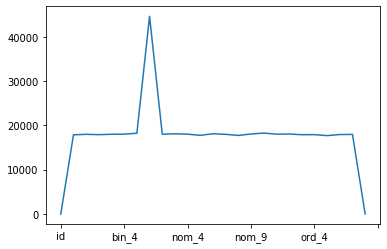

In [78]:
train.isnull().sum().plot()

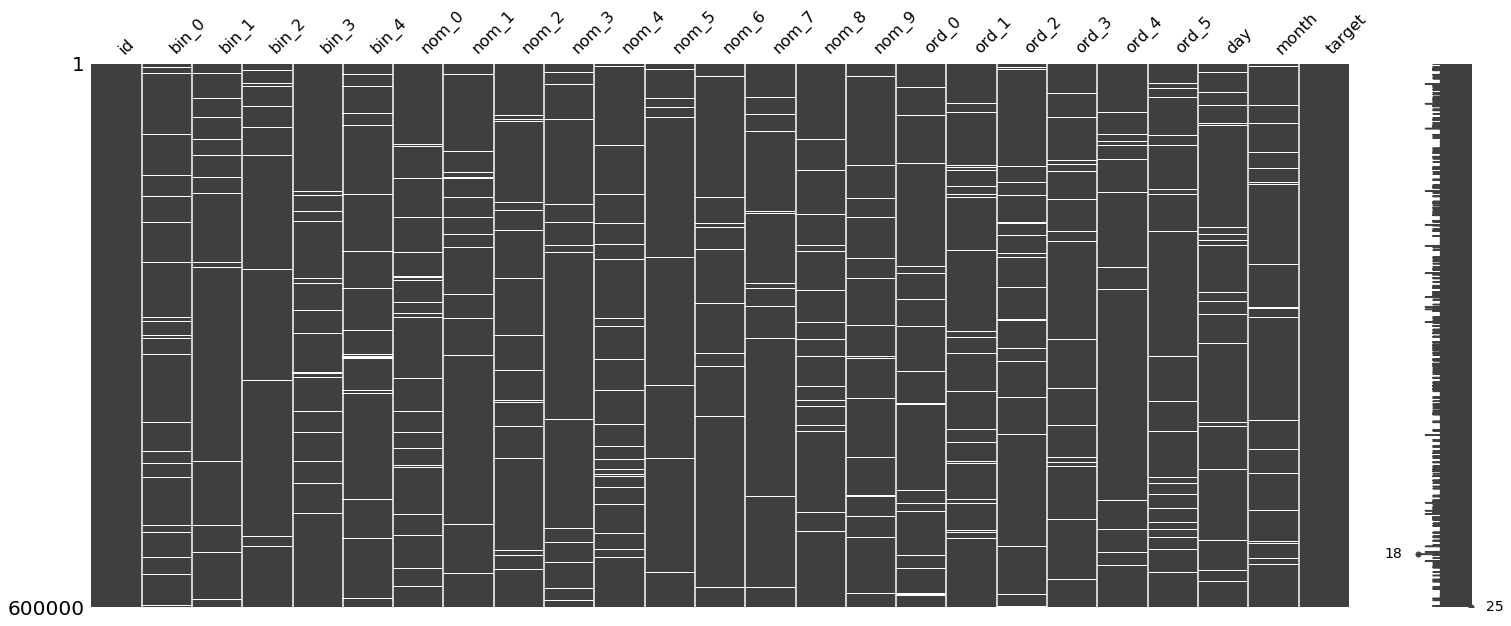

In [50]:
import pandas as pd 
import missingno as msno 
  
# Visualize missing values as a matrix 
msno.matrix(train) 

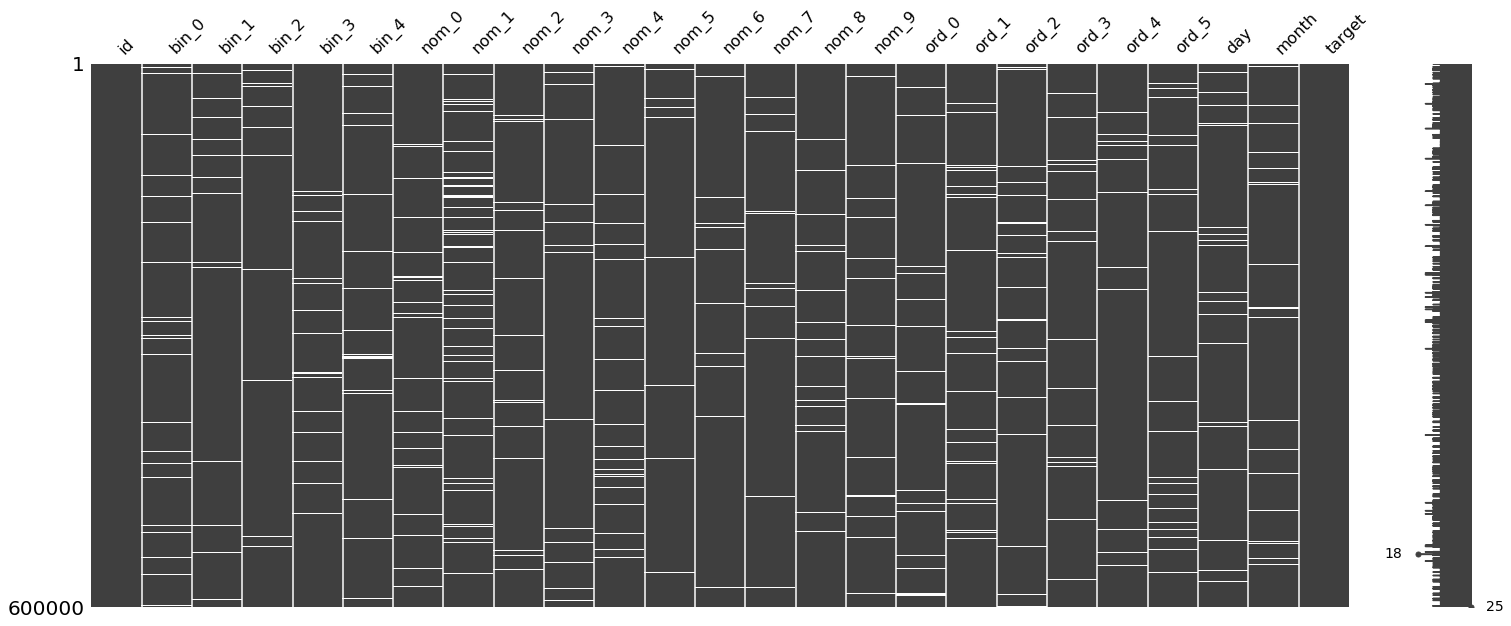

In [61]:
import pandas as pd 
import missingno as msno 
  
# Visualize missing values as a matrix 
msno.matrix(train) 

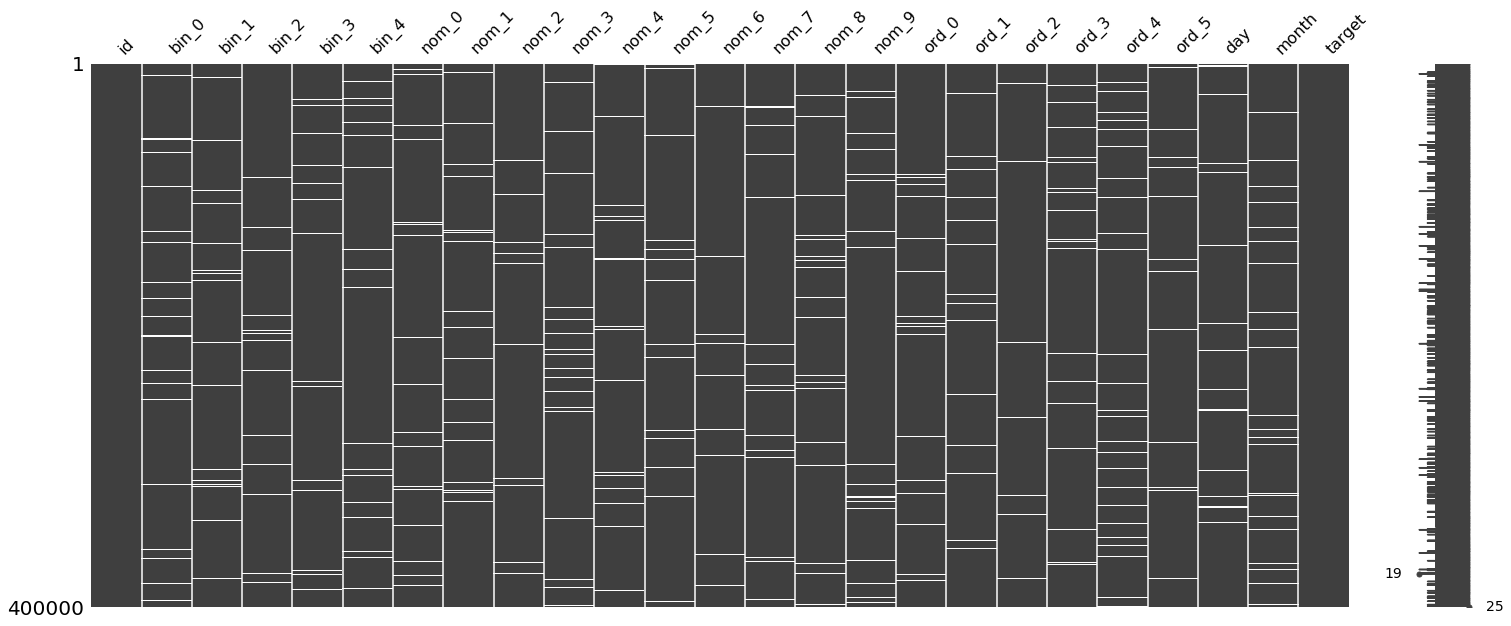

In [38]:
msno.matrix(test)

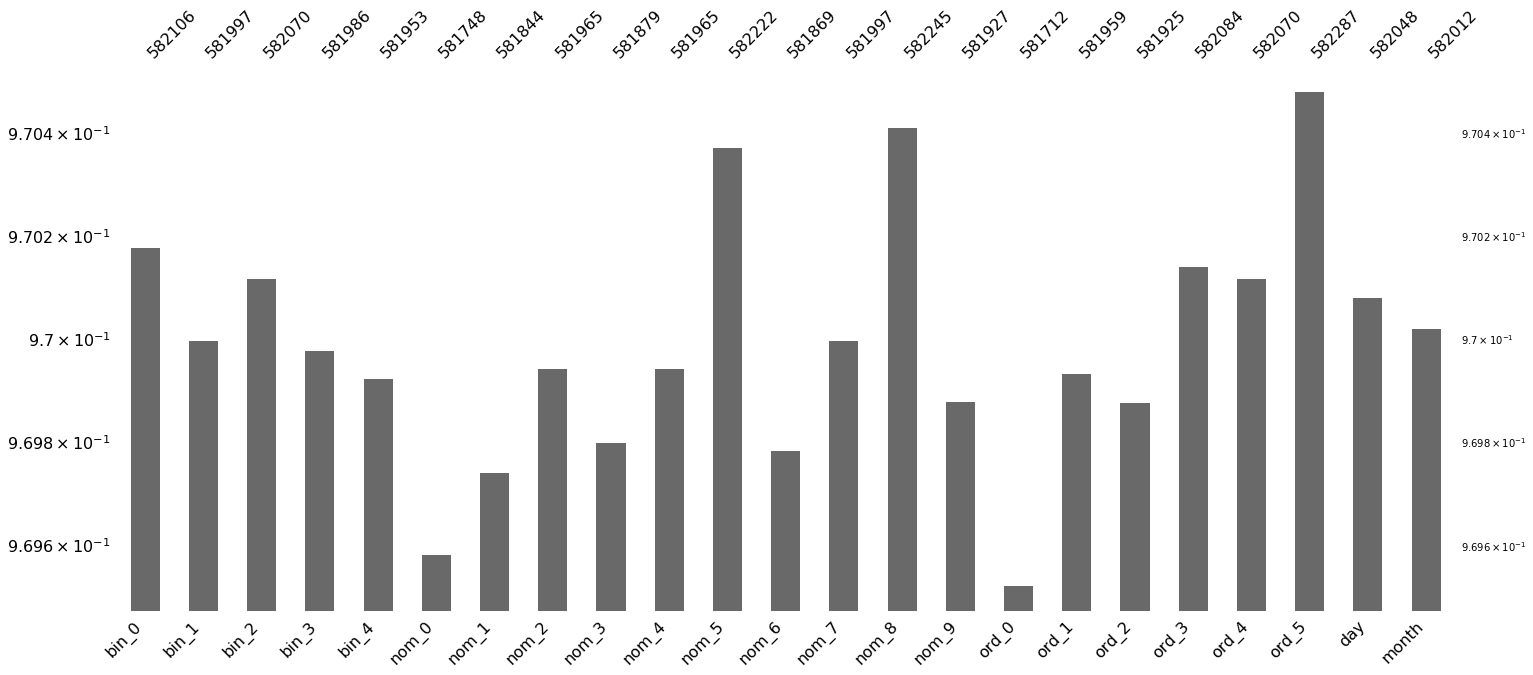

In [72]:
msno.bar(train.drop(columns=['id', 'target']), log=True)

In [77]:
train.isnull().sum()

id            0
bin_0     17894
bin_1     18003
bin_2     17930
bin_3     18014
bin_4     18047
nom_0     18252
nom_1     44659
nom_2     18035
nom_3     18121
nom_4     18035
nom_5     17778
nom_6     18131
nom_7     18003
nom_8     17755
nom_9     18073
ord_0     18288
ord_1     18041
ord_2     18075
ord_3     17916
ord_4     17930
ord_5     17713
day       17952
month     17988
target        0
dtype: int64

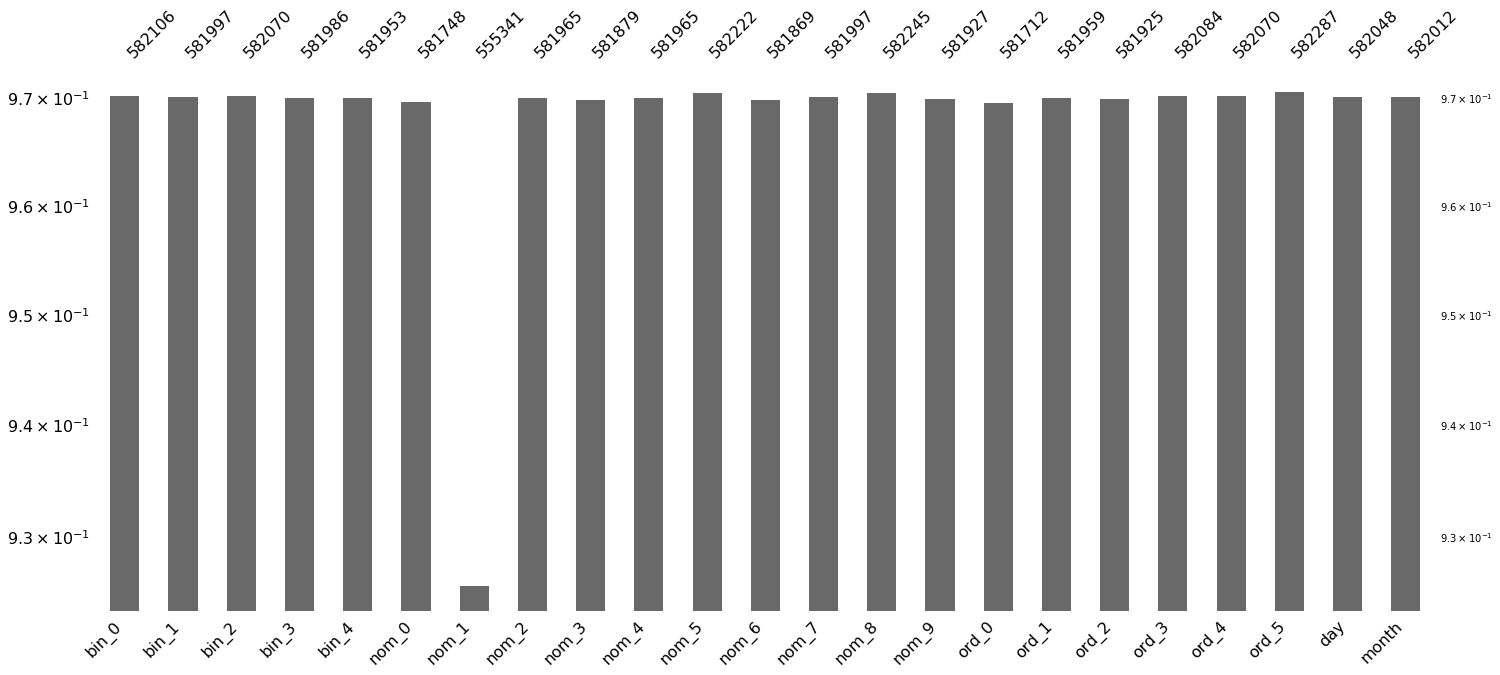

In [75]:
msno.bar(train.drop(columns=['id', 'target']), log=True)

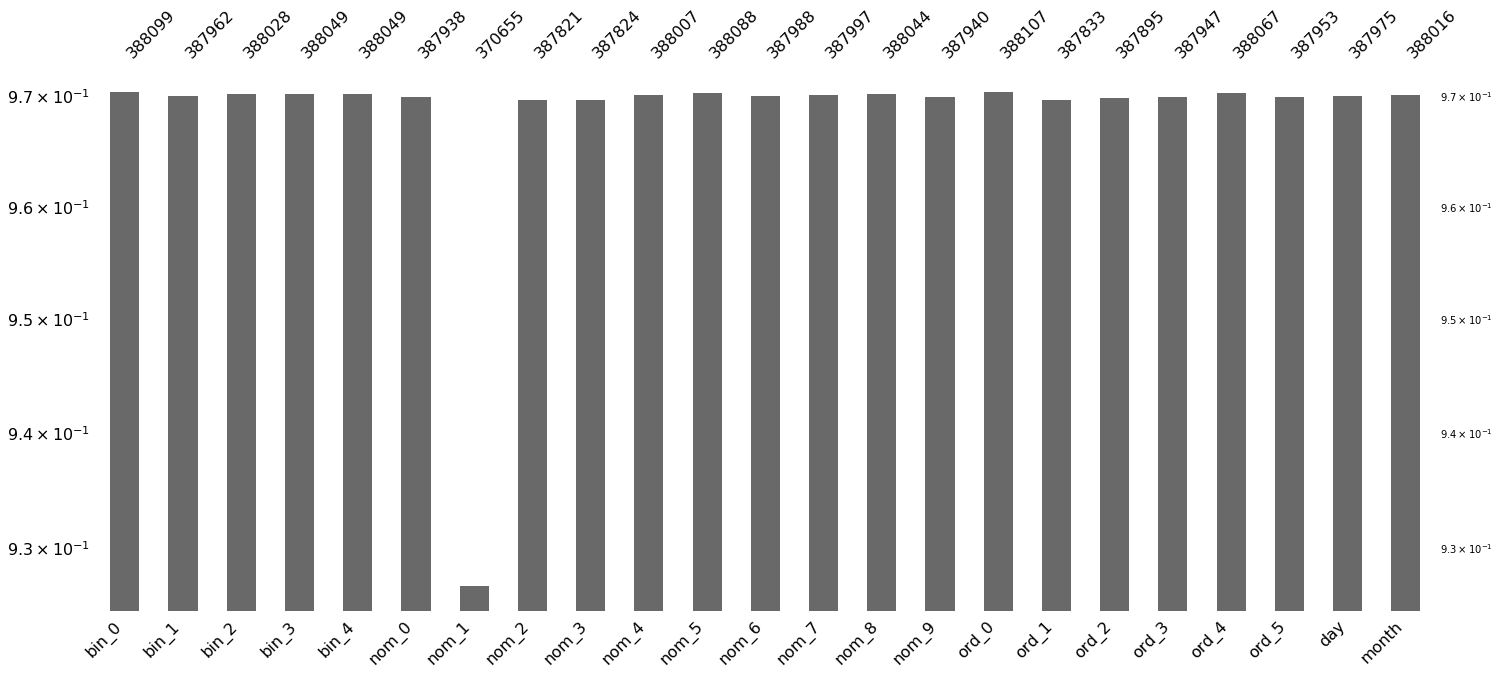

In [30]:
msno.bar(test.drop(columns=['id', 'target']), log=True)

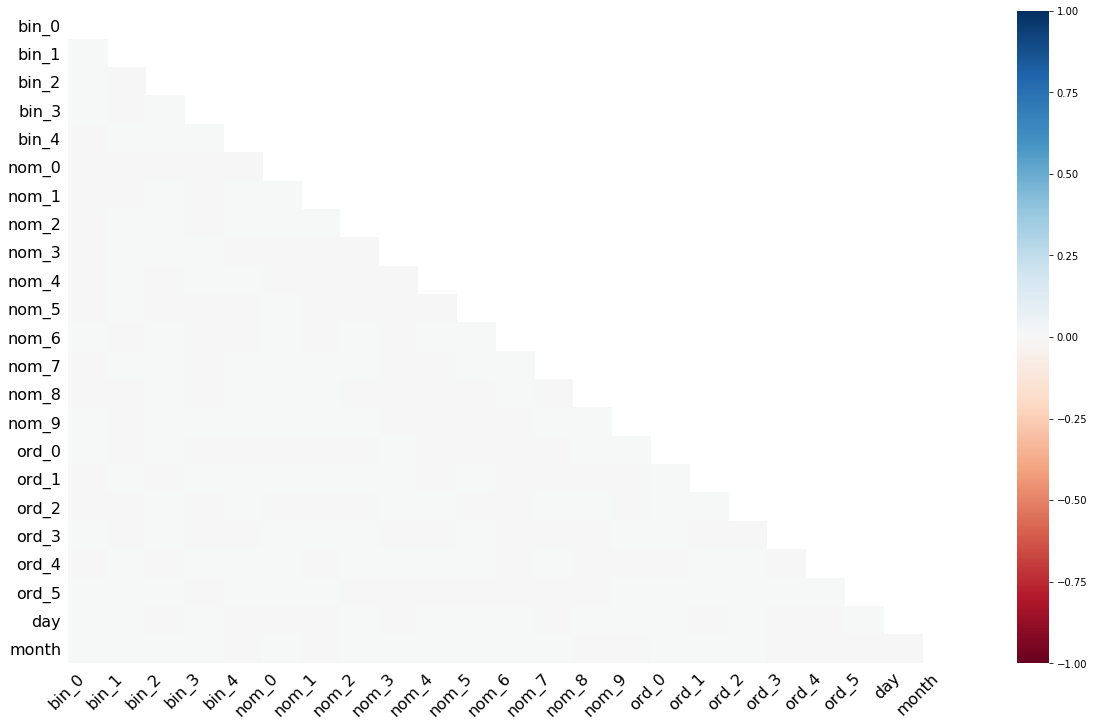

In [25]:
msno.heatmap(train)

In [17]:
test.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,600000,0.0,0.0,0.0,F,Y,Blue,Polygon,Axolotl,Finland,...,fced9e114,3.0,Novice,Boiling Hot,f,U,oU,3.0,9.0,-1
1,600001,0.0,0.0,0.0,F,Y,Red,Circle,Lion,Russia,...,7ca8775da,1.0,Novice,Cold,n,N,NaN,2.0,8.0,-1
2,600002,0.0,0.0,0.0,F,Y,Blue,Circle,Axolotl,Russia,...,5940334c9,1.0,Expert,Warm,i,N,DN,2.0,6.0,-1
3,600003,1.0,0.0,0.0,F,N,Red,Polygon,Axolotl,Costa Rica,...,6fbdeefc8,1.0,Expert,Hot,m,B,AG,1.0,6.0,-1
4,600004,0.0,0.0,1.0,F,Y,Red,Circle,NaN,Finland,...,2a27c8fde,1.0,Contributor,Lava Hot,o,J,DT,3.0,3.0,-1


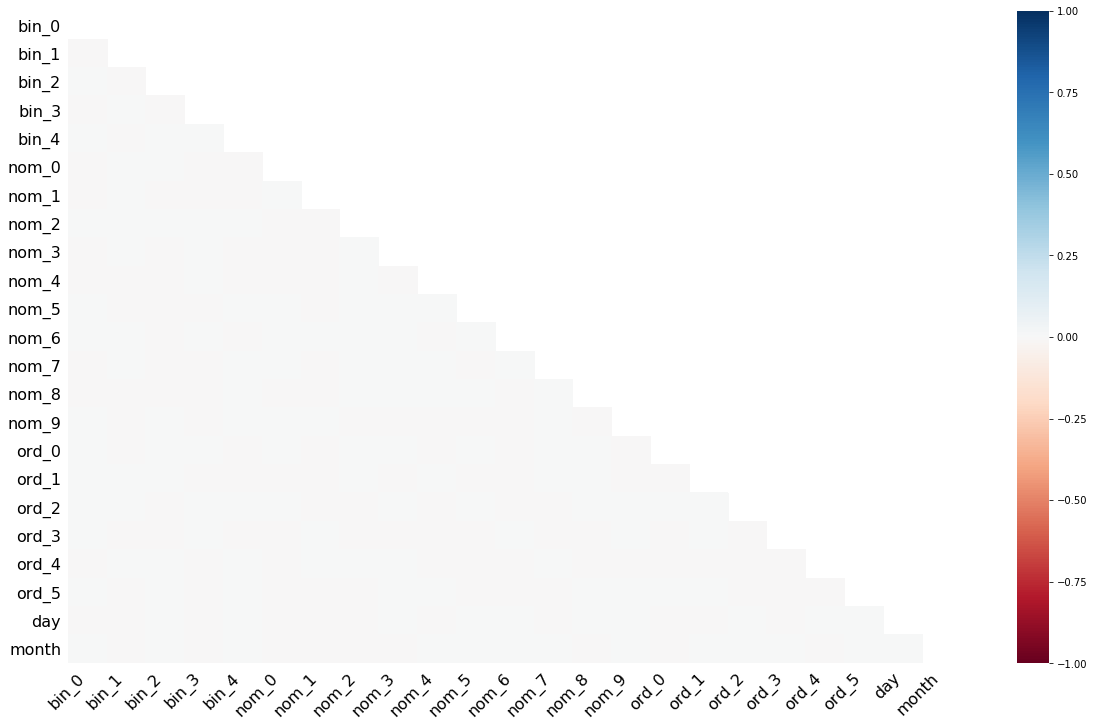

In [16]:
msno.heatmap(test)

In [5]:
data = pd.concat([train, test]).reset_index(drop=True)

In [18]:
sparse_features = [feat for feat in train.columns if feat not in ['id', 'target']]

In [19]:
#data['nan_feature'] = data[sparse_features].isnull().sum(axis=1)

In [20]:
sparse_features = bin_features + nom_features + other_features #+ ['nan_feature']
dense_features = ord_features

# Label encode and fillna

In [21]:
def convert_data_to_numeric(df):
    
    bin_3_mapping = {'T':1 , 'F':0}
    bin_4_mapping = {'Y':1 , 'N':0}
    nom_0_mapping = {'Red' : 0, 'Blue' : 1, 'Green' : 2}
    nom_1_mapping = {'Trapezoid' : 0, 'Star' : 1, 'Circle': 2, 'Triangle' : 3, 'Polygon' : 4}
    nom_2_mapping = {'Hamster' : 0 , 'Axolotl' : 1, 'Lion' : 2, 'Dog' : 3, 'Cat' : 4, 'Snake' : 5}
    nom_3_mapping = {'Russia' : 0, 'Canada' : 1, 'Finland' : 2, 'Costa Rica' : 3, 'China' : 4, 'India' : 5}
    nom_4_mapping = {'Bassoon' : 0, 'Theremin' : 1, 'Oboe' : 2, 'Piano' : 3}
    nom_5_mapping = dict(zip((df.nom_5.dropna().unique()), range(len((df.nom_5.dropna().unique())))))
    nom_6_mapping = dict(zip((df.nom_6.dropna().unique()), range(len((df.nom_6.dropna().unique())))))
    nom_7_mapping = dict(zip((df.nom_7.dropna().unique()), range(len((df.nom_7.dropna().unique())))))
    nom_8_mapping = dict(zip((df.nom_8.dropna().unique()), range(len((df.nom_8.dropna().unique())))))
    nom_9_mapping = dict(zip((df.nom_9.dropna().unique()), range(len((df.nom_9.dropna().unique())))))
    ord_1_mapping = {'Novice' : 0, 'Contributor' : 1, 'Expert' : 2, 'Master': 3, 'Grandmaster': 4}
    ord_2_mapping = { 'Freezing': 0, 'Cold': 1, 'Warm' : 2, 'Hot': 3, 'Boiling Hot' : 4, 'Lava Hot' : 5}
    ord_3_mapping = {'a':0, 'b':1, 'c':2 ,'d':3 ,'e':4, 'f':5, 'g':6, 'h':7, 'i':8, 'j':9, 'k':10, 'l':11, 'm':12, 'n':13, 'o':14}
    ord_4_mapping = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'J':9, 'K':10,'L':11,'M':12,
                 'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,'Z':25}
    sorted_ord_5 = sorted(df.ord_5.dropna().unique())
    ord_5_mapping = dict(zip(sorted_ord_5, range(len(sorted_ord_5))))

    df['bin_3'] = df.loc[df.bin_3.notnull(), 'bin_3'].map(bin_3_mapping)
    df['bin_4'] = df.loc[df.bin_4.notnull(), 'bin_4'].map(bin_4_mapping)
    df['nom_0'] = df.loc[df.nom_0.notnull(), 'nom_0'].map(nom_0_mapping)
    df['nom_1'] = df.loc[df.nom_1.notnull(), 'nom_1'].map(nom_1_mapping)
    df['nom_2'] = df.loc[df.nom_2.notnull(), 'nom_2'].map(nom_2_mapping)
    df['nom_3'] = df.loc[df.nom_3.notnull(), 'nom_3'].map(nom_3_mapping)
    df['nom_4'] = df.loc[df.nom_4.notnull(), 'nom_4'].map(nom_4_mapping)
    df['nom_5'] = df.loc[df.nom_5.notnull(), 'nom_5'].map(nom_5_mapping)
    df['nom_6'] = df.loc[df.nom_6.notnull(), 'nom_6'].map(nom_6_mapping)
    df['nom_7'] = df.loc[df.nom_7.notnull(), 'nom_7'].map(nom_7_mapping)
    df['nom_8'] = df.loc[df.nom_8.notnull(), 'nom_8'].map(nom_8_mapping)
    df['nom_9'] = df.loc[df.nom_9.notnull(), 'nom_9'].map(nom_9_mapping)
    df['ord_1'] = df.loc[df.ord_1.notnull(), 'ord_1'].map(ord_1_mapping)
    df['ord_2'] = df.loc[df.ord_2.notnull(), 'ord_2'].map(ord_2_mapping)
    df['ord_3'] = df.loc[df.ord_3.notnull(), 'ord_3'].map(ord_3_mapping)
    df['ord_4'] = df.loc[df.ord_4.notnull(), 'ord_4'].map(ord_4_mapping)
    df['ord_5'] = df.loc[df.ord_5.notnull(), 'ord_5'].map(ord_5_mapping)
    
    return df

## Define sparse features

In [22]:
# Create NaN count
# data['nan_count'] = data.isnull().sum(axis=1) Problem with nan count

features = [feat for feat in data.columns if feat not in ['id', 'target']]#, 'nan_feature']]

## Keep categories present in train AND test

In [23]:
train = data[data.target != -1]
test = data[data.target == -1]

In [23]:
for col in features:
    train_unique_values = set(train[col].dropna().unique())
    test_unique_values  = set(test[col].dropna().unique())

    symmetric_difference_values = train_unique_values.symmetric_difference(test_unique_values)
    if symmetric_difference_values:
        print(f'{len(symmetric_difference_values)} values in {col}, {symmetric_difference_values} Replaced with nan')
        data.loc[data[col].isin(symmetric_difference_values), col] = np.nan

1 values in nom_5, {'b3ad70fcb'} Replaced with nan
4 values in nom_6, {'f0732a795', 'a885aacec', '3a121fefb', 'ee6983c6d'} Replaced with nan
2 values in nom_9, {'1065f10dd', '3d19cd31d'} Replaced with nan


## Fillna

In [ ]:
%%time
features = [feat for feat in data.columns if feat not in ['target','id']]
data[features] = convert_data_to_numeric(data[features])
data[features] = data[features].astype('category')
imp = IterativeImputer(max_iter=500, initial_strategy='most_frequent', random_state=SEED, add_indicator=True)
indicator_cols = [feat + '_ind' for feat in features]
for col in indicator_cols:
    data[col] = 0
data[features+indicator_cols] = imp.fit_transform(data[features])
data[features] = data[features].round(0).astype(np.int16)
data[indicator_cols] = data[indicator_cols].astype(np.uint8)

In [24]:
data[features] = convert_data_to_numeric(data[features])
data[sparse_features] = data[sparse_features].fillna(-1) + 1

In [27]:
train = data[data.target != -1].reset_index(drop=True)
test  = data[data.target == -1].reset_index(drop=True)

In [28]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='median')
train[dense_features] = imp.fit_transform(train[dense_features])
test[dense_features] = imp.transform(test[dense_features])

# Standard scale dense_features

In [29]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

train[dense_features] = std.fit_transform(train[dense_features])
test[dense_features] = std.transform(test[dense_features])

## Treat days

# Define Keras model

## Define functions

In [30]:
def auc(y_true, y_pred):
    def fallback_auc(y_true, y_pred):
        try:
            return roc_auc_score(y_true, y_pred)
        except:
            return 0.5
    return tf.py_function(fallback_auc, (y_true, y_pred), tf.double)

In [31]:
class CyclicLR(keras.callbacks.Callback):

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2. ** (x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** (x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(
                self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        K.set_value(self.model.optimizer.lr, self.clr())


## Define Hyperparams

In [32]:
target = ['target']
N_Splits = 5
Verbose = 1
Epochs = 50
BATCH_SIZE = 512

DROPOUT = 0.3
NNLAYERS = (300, 300)
PATIENCE = 5

MAX_EMB_DIM = 50

In [33]:
def create_model(data, catcols, densecols, sparse_features_emb, max_emb_dim, dnn_layers, last_dense):
    """
    """
    inputs = []
    outputs = []
    outputs_emb = []
    
    # Cat cols
    for c in catcols:
        
        num_unique_values = int(data[c].nunique())
        
        if sparse_features_emb[c]:
            embed_dim = sparse_features_emb[c]
        else:
            embed_dim = int(min(np.ceil(num_unique_values*0.5), max_emb_dim))
            
        inp = layers.Input(shape=(1,))
        out = layers.Embedding(
            num_unique_values + 1, 
            embed_dim, 
            name=c, 
#             activity_regularizer=regularizers.l1(0.01)
        )(inp)
        out = layers.SpatialDropout1D(DROPOUT)(out)
        out = layers.Reshape(target_shape=(embed_dim, ))(out)
        inputs.append(inp)
        outputs.append(out)
        
    # First dense for embeddings
#     outputs_emb = layers.Concatenate()(outputs_emb)
#     outputs_emb = layers.Dense(last_dense, activation="relu")(outputs_emb)
#     outputs_emb = layers.Dropout(DROPOUT)(outputs_emb)
        
    # Dense cols
    if densecols:
        dense_inp = layers.Input(shape=(len(densecols),))
        inputs.append(dense_inp)
        outputs.append(dense_inp)
        
    x = layers.Concatenate()(outputs)
#     x = layers.BatchNormalization()(x)
    
    # DNN layers
    for size in dnn_layers:
#         x = layers.Concatenate()([x, outputs_emb])
#         x = layers.BatchNormalization()(x)
        x = layers.Dense(size, activation="relu")(x)
        x = layers.Dropout(DROPOUT)(x)
        
#     x = layers.Concatenate()([x, outputs_emb])
    
#     x = layers.BatchNormalization()(x)
    
    y = layers.Dense(2, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=y)
    return model


In [27]:
# all_features = dense_features + sparse_features + ['target']

In [34]:
all_features = features + ['target']

In [35]:
def run_cv(
    sparse_features, 
    dense_features,
    sparse_features_emb,
    max_emb_dim, 
    nn_layers=(300, 300), 
    last_dense=256, 
    n_splits=N_Splits,
    verbose=Verbose
):
    """
    """
    np.random.seed(SEED)

    random.seed(SEED)

    tf.set_random_seed(SEED)
    
    oof_pred_deepfm = np.zeros((len(train), ))
    y_pred_deepfm = np.zeros((len(test),))

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    all_features = sparse_features + dense_features + ['target']

    for fold, (tr_ind, val_ind) in enumerate(skf.split(train, train[target])):

        # Split
        X_train, X_val = train[all_features].iloc[tr_ind], train[all_features].iloc[val_ind]
        y_train, y_val = train[target].iloc[tr_ind], train[target].iloc[val_ind]
        
        train_model_input = [X_train.loc[:, sparse_features].values[:, k] \
                             for k in range(X_train.loc[:, sparse_features].values.shape[1])]
        if dense_features:
            train_model_input += [X_train.loc[:, dense_features].values]
        
        val_model_input = [X_val.loc[:, sparse_features].values[:, k] \
                           for k in range(X_val.loc[:, sparse_features].values.shape[1])]
        if dense_features:
            val_model_input += [X_val.loc[:, dense_features].values]
        
        test_model_input = [test.loc[:, sparse_features].values[:, k] \
                            for k in range(X_val.loc[:, sparse_features].values.shape[1])]
        if dense_features:
            test_model_input += [test.loc[:, dense_features].values]


        # Define model
        model = create_model(data, sparse_features, dense_features, sparse_features_emb, 
                             max_emb_dim, nn_layers, last_dense)
        opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
        model.compile(opt, "binary_crossentropy", metrics=[auc])

        # Define callbacks
        es = callbacks.EarlyStopping(
            monitor='val_auc', 
            min_delta=0.001, 
            patience=PATIENCE, 
            verbose=verbose, 
            mode='max', 
            baseline=None, 
            restore_best_weights=True
        )
        #sb = callbacks.ModelCheckpoint(
         #   './nn_model.w8', save_weights_only=True, save_best_only=True, verbose=Verbose
        #)
    #     clr = CyclicLR(base_lr=0.00001 / 100, max_lr = 0.0001, 
    #                        step_size= int(1.0*(test.shape[0])/1024) , mode='exp_range',
    #                        gamma=1., scale_fn=None, scale_mode='cycle')
        reduce_lr = ReduceLROnPlateau(
            monitor='val_auc', 
            mode='max',
            factor=0.5,
            patience=3, 
            min_lr=1e-6,
            verbose=verbose,
        )

    #     cb = TQDMNotebookCallback()
    #     setattr(cb,'on_train_batch_begin',lambda x,y:None)
    #     setattr(cb,'on_train_batch_end',lambda x,y:None)

        # Train model
        history = model.fit(
            train_model_input, utils.to_categorical(y_train),
            validation_data=(val_model_input, utils.to_categorical(y_val)),
            batch_size=1024, 
            epochs=Epochs, 
            verbose=verbose,
            callbacks=[reduce_lr, es]
        )

        # Predict
        val_pred = model.predict(val_model_input, batch_size=512)[:, 1]
        print(f"validation AUC fold {fold+1} : {round(roc_auc_score(y_val, val_pred), 5)}")
        oof_pred_deepfm[val_ind] = val_pred.ravel()
        y_pred_deepfm += model.predict(test_model_input, batch_size=512)[:, 1].ravel() / (n_splits)
        K.clear_session()
        gc.collect()
    gc.collect()        
    print(f"OOF AUC : {round(roc_auc_score(train.target.values, oof_pred_deepfm), 5)}")
        
    return oof_pred_deepfm, y_pred_deepfm

In [36]:
sparse_features_emb = {
    'bin_0': None,
    'bin_1': None,
    'bin_2': None,
    'bin_3': None,
    'bin_4': None,
    'nom_0': None,
    'nom_1': None,
    'nom_2': None,
    'nom_3': None,
    'nom_4': None,
    'nom_5': None,
    'nom_6': None,
    'nom_7': None,
    'nom_8': None,
    'nom_9': None,
    'day': None,
    'month': None,
    'nan_feature': None
}

In [37]:
#sparse_features_emb = {x: None for x in sparse_features}

In [40]:
oof_pred_deepfm = run_cv(
    sparse_features=sparse_features, 
    dense_features=dense_features,
    sparse_features_emb=sparse_features_emb,
    max_emb_dim=20,
    n_splits=10,
    verbose=0
)

validation AUC fold 1 : 0.79098
validation AUC fold 2 : 0.78633
validation AUC fold 3 : 0.7868
validation AUC fold 4 : 0.78918
validation AUC fold 5 : 0.78738
validation AUC fold 6 : 0.78583
validation AUC fold 7 : 0.78719
validation AUC fold 8 : 0.7846
validation AUC fold 9 : 0.78415
validation AUC fold 10 : 0.7876
OOF AUC : 0.7865


In [ ]:
oof_pred_deepfm = run_cv(
    sparse_features=sparse_features, 
    dense_features=dense_features,
    sparse_features_emb=sparse_features_emb,
    max_emb_dim=15,
    n_splits=10,
    verbose=0
)

Idea : test submission full sparse + fillna median for ord
if oof > but lb < ==> na is shifted train/test
==> random -1 / median ?

In [26]:
oof_pred_deepfm = run_cv(
    sparse_features=sparse_features, 
    dense_features=[],
    sparse_features_emb=sparse_features_emb,
    max_emb_dim=20,
    n_splits=10,
    verbose=0
)

validation AUC fold 1 : 0.7906
validation AUC fold 2 : 0.78443
validation AUC fold 3 : 0.78504
validation AUC fold 4 : 0.78845
validation AUC fold 5 : 0.78519
validation AUC fold 6 : 0.78447
validation AUC fold 7 : 0.78487
validation AUC fold 8 : 0.78482
validation AUC fold 9 : 0.78436
validation AUC fold 10 : 0.78792
OOF AUC : 0.78554


### 10 Fold

* Max emb dim 50 = 100 OOF AUC :  (ln(dim))
* Max emb dim 50 OOF AUC : 0.78482 (dim*0.5)
* Max emb dim 100 OOF AUC :  (dim*0.5)
* Max emb dim 200 OOF AUC :  (dim*0.5)
* Max emb dim 20 OOF AUC : 0.78554 (dim*0.5)
* Max emb dim 15 OOF AUC : 0.78537 (dim*0.5)
* Max emb dim 20 OOF AUC : 0.7865 (dim*0.5) + std ord
* Max emb dim 10 OOF AUC :  (dim*0.5) + std ord + nan_feature
* Max emb dim 15 OOF AUC :  (dim*0.5) + std ord + nan_feature

### 5 Fold

* Max emb dim 50 = 100 OOF AUC : 0.78486 (ln(dim))
* Max emb dim 50 OOF AUC : 0.7851 (dim*0.5)
* Max emb dim 100 OOF AUC : 0.7843 (dim*0.5)
* Max emb dim 200 OOF AUC : 0.78327 (dim*0.5)
* Max emb dim 20 OOF AUC : 0.78576 (dim*0.5)
* Max emb dim 10 OOF AUC : 0.78557 (dim*0.5)
* Max emb dim 20 OOF AUC : 0.78576 (dim*0.5) + std ord + nan_feature
* Max emb dim 10 OOF AUC : 0.7864 (dim*0.5) + std ord + nan_feature
* Max emb dim 15 OOF AUC : 0.78652 (dim*0.5) + std ord + nan_feature

In [ ]:
def AntMapping(df, ordinal):
    ord_maps = {
        'ord_0': {val: i for i, val in enumerate([1, 2, 3])},
        'ord_1': {
            val: i
            for i, val in enumerate(
                ['Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster']
            )
        },
        'ord_2': {
            val: i
            for i, val in enumerate(
                ['Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot']
            )
        },
        **{col: {val: i for i, val in enumerate(sorted(df[col].dropna().unique()))} for col in ['ord_3', 'ord_4', 'ord_5', 'day', 'month']},
    }
    ord_cols = pd.concat([df[col].map(ord_map).fillna(max(ord_map.values())//2).astype('float32') for col, ord_map in ord_maps.items()], axis=1)
    ord_cols /= ord_cols.max()
    ord_sqr = 4*(ord_cols - 0.5)**2
    ord_cols_sqr = [feat+'_sqr' for feat in ordinal]
    df[ordinal] = ord_cols
    df[ord_cols_sqr] = ord_sqr
    return df

In [3]:
from sklearn.model_selection import ParameterSampler
sparse_emb_dims = {
    'bin_0': [None],
    'bin_1': [None],
    'bin_2': [None],
    'bin_3': [None],
    'bin_4': [None],
    'nom_0': [None],
    'nom_1': [None],
    'nom_2': [None],
    'nom_3': [None],
    'nom_4': [None],
    'nom_5': [5, 10, 15, 20],
    'nom_6': [5, 10, 15, 20],
    'nom_7': [5, 10, 15, 20],
    'nom_8': [5, 10, 15, 20],
    'nom_9': [5, 10, 15, 20],
    'day': [None],
    'month': [None],
    'nan_feature': [None]    
}
list_params = list(ParameterSampler(sparse_emb_dims,
                                    n_iter=20,
                                    random_state=SEED))

In [4]:
list_params

[{'nom_9': 5,
  'nom_8': 20,
  'nom_7': 20,
  'nom_6': 5,
  'nom_5': 10,
  'nom_4': None,
  'nom_3': None,
  'nom_2': None,
  'nom_1': None,
  'nom_0': None,
  'nan_feature': None,
  'month': None,
  'day': None,
  'bin_4': None,
  'bin_3': None,
  'bin_2': None,
  'bin_1': None,
  'bin_0': None},
 {'nom_9': 10,
  'nom_8': 15,
  'nom_7': 20,
  'nom_6': 15,
  'nom_5': 15,
  'nom_4': None,
  'nom_3': None,
  'nom_2': None,
  'nom_1': None,
  'nom_0': None,
  'nan_feature': None,
  'month': None,
  'day': None,
  'bin_4': None,
  'bin_3': None,
  'bin_2': None,
  'bin_1': None,
  'bin_0': None},
 {'nom_9': 5,
  'nom_8': 20,
  'nom_7': 10,
  'nom_6': 15,
  'nom_5': 10,
  'nom_4': None,
  'nom_3': None,
  'nom_2': None,
  'nom_1': None,
  'nom_0': None,
  'nan_feature': None,
  'month': None,
  'day': None,
  'bin_4': None,
  'bin_3': None,
  'bin_2': None,
  'bin_1': None,
  'bin_0': None},
 {'nom_9': 10,
  'nom_8': 5,
  'nom_7': 10,
  'nom_6': 20,
  'nom_5': 10,
  'nom_4': None,
  'nom_3'

In [ ]:
for list_param in list_params:
    oof_pred_deepfm = run_cv(
    sparse_features=sparse_features, 
    dense_features=dense_features,
    sparse_features_emb=list_param,
    max_emb_dim=15,
    verbose=0
)

validation AUC fold 1 : 0.78724
validation AUC fold 2 : 0.78784
validation AUC fold 3 : 0.78665
validation AUC fold 4 : 0.78599
validation AUC fold 5 : 0.78698
OOF AUC : 0.78667
validation AUC fold 1 : 0.78755
validation AUC fold 2 : 0.78747
validation AUC fold 3 : 0.78678
validation AUC fold 4 : 0.78538
validation AUC fold 5 : 0.78565
OOF AUC : 0.78624
validation AUC fold 1 : 0.78729
validation AUC fold 2 : 0.78754
validation AUC fold 3 : 0.78678
validation AUC fold 4 : 0.78528
validation AUC fold 5 : 0.78605
OOF AUC : 0.78638
validation AUC fold 1 : 0.78742
validation AUC fold 2 : 0.78784
validation AUC fold 3 : 0.78672
validation AUC fold 4 : 0.78554
validation AUC fold 5 : 0.78618
OOF AUC : 0.78649
validation AUC fold 1 : 0.78767
validation AUC fold 2 : 0.78722
validation AUC fold 3 : 0.78636
validation AUC fold 4 : 0.78547
validation AUC fold 5 : 0.78625
OOF AUC : 0.78635
validation AUC fold 1 : 0.78731
validation AUC fold 2 : 0.78789
validation AUC fold 3 : 0.78671
validation AUC

In [87]:
list_params[0]

{'nom_9': 5,
 'nom_8': 20,
 'nom_7': 15,
 'nom_6': 20,
 'nom_5': 5,
 'nom_4': None,
 'nom_3': None,
 'nom_2': None,
 'nom_1': None,
 'nom_0': None,
 'nan_feature': None,
 'month': None,
 'day': None,
 'bin_4': None,
 'bin_3': None,
 'bin_2': None,
 'bin_1': None,
 'bin_0': None}

In [30]:
sparse_features_emb = {'nom_9': 5,
  'nom_8': 20,
  'nom_7': 20,
  'nom_6': 5,
  'nom_5': 10,
  'nom_4': None,
  'nom_3': None,
  'nom_2': None,
  'nom_1': None,
  'nom_0': None,
  'nan_feature': None,
  'month': None,
  'day': None,
  'bin_4': None,
  'bin_3': None,
  'bin_2': None,
  'bin_1': None,
  'bin_0': None}

oof_pred_deepfm, y_pred_deepfm = run_cv(
    sparse_features=sparse_features, 
    dense_features=dense_features,
    sparse_features_emb=sparse_features_emb,
    max_emb_dim=15,
    n_splits=50,
    verbose=0
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
validation AUC fold 1 : 0.78786
validation AUC fold 2 : 0.79371
validation AUC fold 3 : 0.78787
validation AUC fold 4 : 0.79216
validation AUC fold 5 : 0.79844
validation AUC fold 6 : 0.79143
validation AUC fold 7 : 0.78433
validation AUC fold 8 : 0.79154
validation AUC fold 9 : 0.78202
validation AUC fold 10 : 0.77974
validation AUC fold 11 : 0.78611
validation AUC fold 12 : 0.78918
validation AUC fold 13 : 0.7864
validation AUC fold 14 : 0.79096
validation AUC fold 15 : 0.78313
validation AUC fold 16 : 0.78604
validation AUC fold 17 : 0.7876
validation AUC fold 18 : 0.79602
validation AUC fold 19 : 0.79693
validation AUC fold 20 : 0.78324
validation AUC fold 2

In [31]:
test_idx = test.id.values
submission = pd.DataFrame.from_dict({
    'id': test_idx,
    'target': y_pred_deepfm
})
submission.to_csv("submission_kerasembprepro02_cv_50.csv", index=False)
print("Submission file saved!")

Submission file saved!


In [32]:
np.save('oof_pred_kerasembprepro02_cv_50.npy',oof_pred_deepfm)
np.save('y_pred_kerasembprepro02_cv_50.npy',    y_pred_deepfm)

In [ ]:
oof_pred_deepfm = run_cv()

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values, oof_pred_deepfm), 5)}")
# Max emb dim 50

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values, oof_pred_deepfm), 5)}")
# Max emb dim 100

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values, oof_pred_deepfm), 5)}")
# Max emb dim 100 std scaler

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values, oof_pred_deepfm), 5)}")
# Max emb dim 50 std scaler

* fillna median + std scale ord (not nan feature) + create indicators

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values, oof_pred_deepfm), 5)}")
#ln dim maxembdim 50 no BN

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values, oof_pred_deepfm), 5)}")
#ln dim maxembdim 20 no BN

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values, oof_pred_deepfm), 5)}")
#ln dim maxembdim 200 no BN

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values, oof_pred_deepfm), 5)}")
#ln dim maxembdim 100 no BN

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values, oof_pred_deepfm), 5)}")
# No BN

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values, oof_pred_deepfm), 5)}")

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values, oof_pred_deepfm), 5)}")

0.7848 - 0.7852

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values, oof_pred_deepfm), 5)}")

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values, oof_pred_deepfm), 5)}")

* test with nan_count
* add dense features OK
* test with ln instead of *0.5 OK
* increase MAX_EMB_DIM OK
* archi

In [ ]:
target = ['target']
N_Splits = 5
Verbose = 1
Epochs = 50
BATCH_SIZE = 512

DROPOUT = 0.3
NNLAYERS = (300, 300)
PATIENCE = 5

MAX_EMB_DIM = 100

In [ ]:
dense_features = features_enc
all_features = features + features_enc

In [ ]:
def create_model(data, catcols, densecols, dnn_layers, last_dense):
    """
    """
    inputs = []
    outputs = []
    dense_out = []
    
    # Cat cols
    for c in catcols:
        
        num_unique_values = int(data[c].nunique())
        embed_dim = int(min(np.ceil(math.log(num_unique_values)), MAX_EMB_DIM))
        inp = layers.Input(shape=(1,))
        out = layers.Embedding(num_unique_values + 1, embed_dim, name=c)(inp)
        out = layers.SpatialDropout1D(DROPOUT)(out)
        out = layers.Reshape(target_shape=(embed_dim, ))(out)
        inputs.append(inp)
        outputs.append(out)
        
#     First dense for embeddings
#     outputs_emb = layers.Concatenate()(outputs_emb)
#     outputs_emb = layers.Dense(last_dense, activation="relu")(outputs_emb)
#     outputs_emb = layers.Dropout(DROPOUT)(outputs_emb)

#     outputs_emb = layers.Concatenate()(outputs_emb)
#     outputs_emb = layers.Dense(last_dense, activation="relu")(outputs_emb)
#     outputs_emb = layers.Dropout(DROPOUT)(outputs_emb)
        
    # Dense cols
    if densecols:
        dense_inp = layers.Input(shape=(len(densecols),))
        inputs.append(dense_inp)

    dense_inp = layers.Dense(
        last_dense, 
        activation="relu",
        kernel_regularizer=keras.regularizers.l2(0.01)
    )(dense_inp)
    dense_inp = layers.Dropout(0.5)(dense_inp)
        
    x = layers.Concatenate()(outputs)
#     x = layers.BatchNormalization()(x)
    
    # DNN layers
    for size in dnn_layers:
#         x = layers.Concatenate()([x, outputs_emb])
#         x = layers.BatchNormalization()(x)
        x = layers.Dense(size, activation="relu")(x)
        x = layers.Dropout(DROPOUT)(x)
        
    x = layers.Concatenate()([x, dense_inp])
    
#     x = layers.BatchNormalization()(x)
    
    y = layers.Dense(2, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=y)
    return model


In [ ]:
def run_cv():
    """
    """
    oof_pred_deepfm = np.zeros((len(train), ))
    y_pred_deepfm = np.zeros((len(test),))

    skf = StratifiedKFold(n_splits=N_Splits, shuffle=True, random_state=SEED)


    for fold, (tr_ind, val_ind) in enumerate(skf.split(train, train[target])):

        # Split
        X_train, X_val = train[all_features].iloc[tr_ind], train[all_features].iloc[val_ind]
        y_train, y_val = train[target].iloc[tr_ind], train[target].iloc[val_ind]
        train_model_input = [X_train.loc[:, sparse_features].values[:, k] \
                             for k in range(X_train.loc[:, sparse_features].values.shape[1])]
        train_model_input += [X_train.loc[:, dense_features].values]
        val_model_input = [X_val.loc[:, sparse_features].values[:, k] \
                           for k in range(X_val.loc[:, sparse_features].values.shape[1])]
        val_model_input += [X_val.loc[:, dense_features].values]
        test_model_input = [test.loc[:, sparse_features].values[:, k] \
                            for k in range(X_val.loc[:, sparse_features].values.shape[1])]
        test_model_input += [test.loc[:, dense_features].values]


        # Define model
        model = create_model(data, sparse_features, dense_features, (300, 300), 32)
        opt = keras.optimizers.Adam(learning_rate=1e-3)
        model.compile(opt, "binary_crossentropy", metrics=[auc])

        # Define callbacks
        es = callbacks.EarlyStopping(
            monitor='val_auc', 
            min_delta=0.001, 
            patience=PATIENCE, 
            verbose=Verbose, 
            mode='max', 
            baseline=None, 
            restore_best_weights=True
        )
        #sb = callbacks.ModelCheckpoint(
         #   './nn_model.w8', save_weights_only=True, save_best_only=True, verbose=Verbose
        #)
    #     clr = CyclicLR(base_lr=0.00001 / 100, max_lr = 0.0001, 
    #                        step_size= int(1.0*(test.shape[0])/1024) , mode='exp_range',
    #                        gamma=1., scale_fn=None, scale_mode='cycle')
        reduce_lr = ReduceLROnPlateau(
            monitor='val_auc', 
            mode='max',
            factor=0.5,
            patience=3, 
            min_lr=1e-6,
            verbose=True,
        )

    #     cb = TQDMNotebookCallback()
    #     setattr(cb,'on_train_batch_begin',lambda x,y:None)
    #     setattr(cb,'on_train_batch_end',lambda x,y:None)

        # Train model
        history = model.fit(
            train_model_input, utils.to_categorical(y_train),
            validation_data=(val_model_input, utils.to_categorical(y_val)),
            batch_size=1024, 
            epochs=Epochs, 
            verbose=1,
            callbacks=[reduce_lr, es]
        )

        # Predict
        val_pred = model.predict(val_model_input, batch_size=512)[:, 1]
        print(f"validation AUC fold {fold+1} : {round(roc_auc_score(y_val, val_pred), 5)}")
        oof_pred_deepfm[val_ind] = val_pred.ravel()
        y_pred_deepfm += model.predict(test_model_input, batch_size=512)[:, 1].ravel() / (N_Splits)
        K.clear_session()
        
    return oof_pred_deepfm

In [ ]:
oof_pred_deepfm = run_cv()

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values, oof_pred_deepfm), 5)}")
#ln dim maxembdim 100 no BN (300, 300), 32 reg 0.01

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values, oof_pred_deepfm), 5)}")
#ln dim maxembdim 100 no BN (300, 300), 128 reg 0.001

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values, oof_pred_deepfm), 5)}")
#ln dim maxembdim 100 no BN (300, 300), 128 no reg

* add nan_features OK
* archi

In [ ]:
target = ['target']
N_Splits = 5
Verbose = 1
Epochs = 50
BATCH_SIZE = 512

DROPOUT = 0.3
NNLAYERS = (300, 300)
PATIENCE = 5

MAX_EMB_DIM = 100

In [ ]:
import math

In [ ]:
dense_features = features_enc
all_features = features + indicator_cols + features_enc

In [ ]:
sparse_features += indicator_cols

In [ ]:
all_features = features + ['nan_features']

In [ ]:
def create_model(data, catcols, densecols, dnn_layers, last_dense):
    """
    """
    inputs = []
    outputs = []
    outputs_emb = []
    
    # Cat cols
    for c in catcols:
        
        num_unique_values = int(data[c].nunique())
        embed_dim = int(min(np.ceil(math.log(num_unique_values)), MAX_EMB_DIM))
        inp = layers.Input(shape=(1,))
        out = layers.Embedding(num_unique_values + 1, embed_dim, name=c)(inp)
        out = layers.SpatialDropout1D(DROPOUT)(out)
        out = layers.Reshape(target_shape=(embed_dim, ))(out)
        inputs.append(inp)
        outputs.append(out)
        outputs_emb.append(out)
        
    # First dense for embeddings
#     outputs_emb = layers.Concatenate()(outputs_emb)
#     outputs_emb = layers.Dense(last_dense, activation="relu")(outputs_emb)
#     outputs_emb = layers.Dropout(DROPOUT)(outputs_emb)
        
    # Dense cols
#     if densecols:
#         dense_inp = layers.Input(shape=(len(densecols),))
#         inputs.append(dense_inp)

#         outputs.append(dense_inp)
        
    x = layers.Concatenate()(outputs)
#     x = layers.BatchNormalization()(x)
    
    # DNN layers
    for size in dnn_layers:
#         x = layers.Concatenate()([x, outputs_emb])
#         x = layers.BatchNormalization()(x)
        x = layers.Dense(size, activation="relu")(x)
        x = layers.Dropout(DROPOUT)(x)
        
#     x = layers.Concatenate()([x, outputs_emb])
    
#     x = layers.BatchNormalization()(x)
    
    y = layers.Dense(2, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=y)
    return model


In [ ]:
train.nan_features = train.nan_features.replace({-1: 0})
test.nan_features = test.nan_features.replace({-1: 0})

In [ ]:
sparse_features = sparse_features[:-1]

In [ ]:
def run_cv():
    """
    """
    oof_pred_deepfm = np.zeros((len(train), ))
    y_pred_deepfm = np.zeros((len(test),))

    skf = StratifiedKFold(n_splits=N_Splits, shuffle=True, random_state=SEED)


    for fold, (tr_ind, val_ind) in enumerate(skf.split(train, train[target])):

        # Split
        X_train, X_val = train[all_features].iloc[tr_ind], train[all_features].iloc[val_ind]
        y_train, y_val = train[target].iloc[tr_ind], train[target].iloc[val_ind]
        train_model_input = [X_train.loc[:, sparse_features].values[:, k] \
                             for k in range(X_train.loc[:, sparse_features].values.shape[1])]
    #     train_model_input += [X_train.loc[:, dense_features].values]
        val_model_input = [X_val.loc[:, sparse_features].values[:, k] \
                           for k in range(X_val.loc[:, sparse_features].values.shape[1])]
    #     val_model_input += [X_val.loc[:, dense_features].values]
        test_model_input = [test.loc[:, sparse_features].values[:, k] \
                            for k in range(X_val.loc[:, sparse_features].values.shape[1])]
    #     test_model_input += [test.loc[:, dense_features].values]


        # Define model
        model = create_model(data, sparse_features, ['id'], (300, 300), 256)
        opt = keras.optimizers.Adam(learning_rate=1e-3)
        model.compile(opt, "binary_crossentropy", metrics=[auc])

        # Define callbacks
        es = callbacks.EarlyStopping(
            monitor='val_auc', 
            min_delta=0.001, 
            patience=PATIENCE, 
            verbose=Verbose, 
            mode='max', 
            baseline=None, 
            restore_best_weights=True
        )
        #sb = callbacks.ModelCheckpoint(
         #   './nn_model.w8', save_weights_only=True, save_best_only=True, verbose=Verbose
        #)
    #     clr = CyclicLR(base_lr=0.00001 / 100, max_lr = 0.0001, 
    #                        step_size= int(1.0*(test.shape[0])/1024) , mode='exp_range',
    #                        gamma=1., scale_fn=None, scale_mode='cycle')
        reduce_lr = ReduceLROnPlateau(
            monitor='val_auc', 
            mode='max',
            factor=0.5,
            patience=3, 
            min_lr=1e-6,
            verbose=True,
        )

    #     cb = TQDMNotebookCallback()
    #     setattr(cb,'on_train_batch_begin',lambda x,y:None)
    #     setattr(cb,'on_train_batch_end',lambda x,y:None)

        # Train model
        history = model.fit(
            train_model_input, utils.to_categorical(y_train),
            validation_data=(val_model_input, utils.to_categorical(y_val)),
            batch_size=1024, 
            epochs=Epochs, 
            verbose=1,
            callbacks=[reduce_lr, es]
        )

        # Predict
        val_pred = model.predict(val_model_input, batch_size=512)[:, 1]
        print(f"validation AUC fold {fold+1} : {round(roc_auc_score(y_val, val_pred), 5)}")
        oof_pred_deepfm[val_ind] = val_pred.ravel()
        y_pred_deepfm += model.predict(test_model_input, batch_size=512)[:, 1].ravel() / (N_Splits)
        K.clear_session()
        
    return oof_pred_deepfm

In [ ]:
oof_pred_deepfm = run_cv()

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values, oof_pred_deepfm), 5)}")
#ln dim maxembdim 100 no BN (300, 300) nan features

# CV 50

In [ ]:
target = ['target']
N_Splits = 50
Verbose = 0
Epochs = 50
BATCH_SIZE = 512

DROPOUT = 0.3
NNLAYERS = (300, 300)
PATIENCE = 5

MAX_EMB_DIM = 100

In [ ]:
all_features = features

In [ ]:
def create_model(data, catcols, densecols, dnn_layers, last_dense):
    """
    """
    inputs = []
    outputs = []
    outputs_emb = []
    
    # Cat cols
    for c in catcols:
        
        num_unique_values = int(data[c].nunique())
        embed_dim = int(min(np.ceil(math.log(num_unique_values)), MAX_EMB_DIM))
        inp = layers.Input(shape=(1,))
        out = layers.Embedding(num_unique_values + 1, embed_dim, name=c)(inp)
        out = layers.SpatialDropout1D(DROPOUT)(out)
        out = layers.Reshape(target_shape=(embed_dim, ))(out)
        inputs.append(inp)
        outputs.append(out)
        outputs_emb.append(out)
        
    # First dense for embeddings
#     outputs_emb = layers.Concatenate()(outputs_emb)
#     outputs_emb = layers.Dense(last_dense, activation="relu")(outputs_emb)
#     outputs_emb = layers.Dropout(DROPOUT)(outputs_emb)
        
    # Dense cols
#     if densecols:
#         dense_inp = layers.Input(shape=(len(densecols),))
#         inputs.append(dense_inp)

#         outputs.append(dense_inp)
        
    x = layers.Concatenate()(outputs)
#     x = layers.BatchNormalization()(x)
    
    # DNN layers
    for size in dnn_layers:
#         x = layers.Concatenate()([x, outputs_emb])
#         x = layers.BatchNormalization()(x)
        x = layers.Dense(size, activation="relu")(x)
        x = layers.Dropout(DROPOUT)(x)
        
#     x = layers.Concatenate()([x, outputs_emb])
    
#     x = layers.BatchNormalization()(x)
    
    y = layers.Dense(2, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=y)
    return model


In [ ]:
oof_pred_deepfm = np.zeros((len(train), ))
y_pred_deepfm = np.zeros((len(test),))

skf = StratifiedKFold(n_splits=N_Splits, shuffle=True, random_state=SEED)


for fold, (tr_ind, val_ind) in tqdm(enumerate(skf.split(train, train[target]))):

    # Split
    X_train, X_val = train[all_features].iloc[tr_ind], train[all_features].iloc[val_ind]
    y_train, y_val = train[target].iloc[tr_ind], train[target].iloc[val_ind]
    train_model_input = [X_train.loc[:, sparse_features].values[:, k] \
                         for k in range(X_train.loc[:, sparse_features].values.shape[1])]
#     train_model_input += [X_train.loc[:, dense_features].values]
    val_model_input = [X_val.loc[:, sparse_features].values[:, k] \
                       for k in range(X_val.loc[:, sparse_features].values.shape[1])]
#     val_model_input += [X_val.loc[:, dense_features].values]
    test_model_input = [test.loc[:, sparse_features].values[:, k] \
                        for k in range(X_val.loc[:, sparse_features].values.shape[1])]
#     test_model_input += [test.loc[:, dense_features].values]


    # Define model
    model = create_model(data, sparse_features, ['id'], (300, 300), 256)
    opt = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(opt, "binary_crossentropy", metrics=[auc])

    # Define callbacks
    es = callbacks.EarlyStopping(
        monitor='val_auc', 
        min_delta=0.001, 
        patience=PATIENCE, 
        verbose=Verbose, 
        mode='max', 
        baseline=None, 
        restore_best_weights=True
    )
    #sb = callbacks.ModelCheckpoint(
     #   './nn_model.w8', save_weights_only=True, save_best_only=True, verbose=Verbose
    #)
#     clr = CyclicLR(base_lr=0.00001 / 100, max_lr = 0.0001, 
#                        step_size= int(1.0*(test.shape[0])/1024) , mode='exp_range',
#                        gamma=1., scale_fn=None, scale_mode='cycle')
    reduce_lr = ReduceLROnPlateau(
        monitor='val_auc', 
        mode='max',
        factor=0.5,
        patience=3, 
        min_lr=1e-6,
        verbose=Verbose,
    )

#     cb = TQDMNotebookCallback()
#     setattr(cb,'on_train_batch_begin',lambda x,y:None)
#     setattr(cb,'on_train_batch_end',lambda x,y:None)

    # Train model
    history = model.fit(
        train_model_input, utils.to_categorical(y_train),
        validation_data=(val_model_input, utils.to_categorical(y_val)),
        batch_size=1024, 
        epochs=Epochs, 
        verbose=Verbose,
        callbacks=[reduce_lr, es]
    )

    # Predict
    val_pred = model.predict(val_model_input, batch_size=512)[:, 1]
    print(f"validation AUC fold {fold+1} : {round(roc_auc_score(y_val, val_pred), 5)}")
    oof_pred_deepfm[val_ind] = val_pred.ravel()
    y_pred_deepfm += model.predict(test_model_input, batch_size=512)[:, 1].ravel() / (N_Splits)
    K.clear_session()

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values, oof_pred_deepfm), 5)}")

In [ ]:
test_idx = test.id.values
submission = pd.DataFrame.from_dict({
    'id': test_idx,
    'target': y_pred_deepfm
})
submission.to_csv("submission_kerasemb_cv_50.csv", index=False)
print("Submission file saved!")

In [ ]:
np.save('oof_pred_kerasemb_cv_50.npy',oof_pred_deepfm)
np.save('y_pred_kerasemb_cv_50.npy',    y_pred_deepfm)

# Pseudo labelling

In [ ]:
oof_pred_deepfm = np.load('oof_pred_kerasemb_cv_50.npy')
y_pred_deepfm = np.load('y_pred_kerasemb_cv_50.npy')

In [ ]:
percs, bins = np.histogram(oof_pred_deepfm, bins=500)
precs = [precision_score(train.target.values, (oof_pred_deepfm > thresh).astype(int)) for thresh in bins]
pops = (percs[::-1].cumsum() / 600000)[::-1]

In [ ]:
import plotly.graph_objects as go

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=pops, y=precs[:-1],
                    mode='lines',
                    name='lines'))
#fig.add_trace(go.Scatter(y=bins[:-1], x=precs[:-1],
 #                   mode='lines',
  #                  name='lines'))

fig.show()

In [ ]:
percs, bins = np.histogram(1 - oof_pred_deepfm, bins=500)
precs = [precision_score(1 - train.target.values, ((1 - oof_pred_deepfm) > thresh).astype(int)) for thresh in bins]

pops = (percs[::-1].cumsum() / 600000)[::-1]

In [ ]:
import plotly.graph_objects as go

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=pops, y=precs[:-1],
                    mode='lines',
                    name='lines'))
#fig.add_trace(go.Scatter(y=bins[:-1], x=precs[:-1],
 #                   mode='lines',
  #                  name='lines'))

fig.show()

In [ ]:
np.sort(oof_pred_deepfm)

In [ ]:
def get_pseudo_index(oof_pred, y_pred, pos_frac=0.01, neg_frac=0.08):
    """
    """
    idx_neg = int(neg_frac * len(oof_pred))
    neg_thresh = np.sort(oof_pred)[idx_neg]
    
    idx_pos = int(pos_frac * len(oof_pred))
    pos_thresh = np.sort(oof_pred)[::-1][idx_pos]
    
    neg_indices = np.argwhere(y_pred < neg_thresh)
    pos_indices = np.argwhere(y_pred > pos_thresh)
    
    print(f'Selected {len(pos_indices) * 100. / len(y_pred)}% ({len(pos_indices)}) of test as 1, for threshold {pos_thresh}')
    print(f'Selected {len(neg_indices) * 100. / len(y_pred)}% ({len(neg_indices)}) of test as 0, for threshold {neg_thresh}')
    
    return pos_indices.flatten(), neg_indices.flatten()

In [ ]:
pos_ind, neg_ind = get_pseudo_index(oof_pred_deepfm, y_pred_deepfm)

## CV 50 pseudo labelling

In [ ]:
target = ['target']
N_Splits = 50
Verbose = 0
Epochs = 50
BATCH_SIZE = 512

DROPOUT = 0.3
NNLAYERS = (300, 300)
PATIENCE = 5

MAX_EMB_DIM = 100

In [ ]:
all_features = features

In [ ]:
def create_model(data, catcols, densecols, dnn_layers, last_dense):
    """
    """
    inputs = []
    outputs = []
    outputs_emb = []
    
    # Cat cols
    for c in catcols:
        
        num_unique_values = int(data[c].nunique())
        embed_dim = int(min(np.ceil(math.log(num_unique_values)), MAX_EMB_DIM))
        inp = layers.Input(shape=(1,))
        out = layers.Embedding(num_unique_values + 1, embed_dim, name=c)(inp)
        out = layers.SpatialDropout1D(DROPOUT)(out)
        out = layers.Reshape(target_shape=(embed_dim, ))(out)
        inputs.append(inp)
        outputs.append(out)
        outputs_emb.append(out)
        
    # First dense for embeddings
#     outputs_emb = layers.Concatenate()(outputs_emb)
#     outputs_emb = layers.Dense(last_dense, activation="relu")(outputs_emb)
#     outputs_emb = layers.Dropout(DROPOUT)(outputs_emb)
        
    # Dense cols
#     if densecols:
#         dense_inp = layers.Input(shape=(len(densecols),))
#         inputs.append(dense_inp)

#         outputs.append(dense_inp)
        
    x = layers.Concatenate()(outputs)
#     x = layers.BatchNormalization()(x)
    
    # DNN layers
    for size in dnn_layers:
#         x = layers.Concatenate()([x, outputs_emb])
#         x = layers.BatchNormalization()(x)
        x = layers.Dense(size, activation="relu")(x)
        x = layers.Dropout(DROPOUT)(x)
        
#     x = layers.Concatenate()([x, outputs_emb])
    
#     x = layers.BatchNormalization()(x)
    
    y = layers.Dense(2, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=y)
    return model


In [ ]:
train_bak = train.copy(deep=True)

In [ ]:
pos_df = test.iloc[pos_ind]
pos_df.target = 1

neg_df = test.iloc[neg_ind]
neg_df.target = 0

selected_test = pd.concat([pos_df, neg_df], axis=0).sample(frac=1.0)

In [ ]:
train = pd.concat([train, selected_test], axis=0)

In [ ]:
oof_pred_deepfm = np.zeros((len(train), ))
y_pred_deepfm = np.zeros((len(test),))

skf = StratifiedKFold(n_splits=N_Splits, shuffle=True, random_state=SEED)

for fold, (tr_ind, val_ind) in tqdm(enumerate(skf.split(train, train[target]))):

    # Split
    X_train, X_val = train[all_features].iloc[tr_ind], train[all_features].iloc[val_ind]
    y_train, y_val = train[target].iloc[tr_ind], train[target].iloc[val_ind]
    train_model_input = [X_train.loc[:, sparse_features].values[:, k] \
                         for k in range(X_train.loc[:, sparse_features].values.shape[1])]
#     train_model_input += [X_train.loc[:, dense_features].values]
    val_model_input = [X_val.loc[:, sparse_features].values[:, k] \
                       for k in range(X_val.loc[:, sparse_features].values.shape[1])]
#     val_model_input += [X_val.loc[:, dense_features].values]
    test_model_input = [test.loc[:, sparse_features].values[:, k] \
                        for k in range(X_val.loc[:, sparse_features].values.shape[1])]
#     test_model_input += [test.loc[:, dense_features].values]


    # Define model
    model = create_model(data, sparse_features, ['id'], (300, 300), 256)
    opt = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(opt, "binary_crossentropy", metrics=[auc])

    # Define callbacks
    es = callbacks.EarlyStopping(
        monitor='val_auc', 
        min_delta=0.001, 
        patience=PATIENCE, 
        verbose=Verbose, 
        mode='max', 
        baseline=None, 
        restore_best_weights=True
    )
    #sb = callbacks.ModelCheckpoint(
     #   './nn_model.w8', save_weights_only=True, save_best_only=True, verbose=Verbose
    #)
#     clr = CyclicLR(base_lr=0.00001 / 100, max_lr = 0.0001, 
#                        step_size= int(1.0*(test.shape[0])/1024) , mode='exp_range',
#                        gamma=1., scale_fn=None, scale_mode='cycle')
    reduce_lr = ReduceLROnPlateau(
        monitor='val_auc', 
        mode='max',
        factor=0.5,
        patience=3, 
        min_lr=1e-6,
        verbose=Verbose,
    )

#     cb = TQDMNotebookCallback()
#     setattr(cb,'on_train_batch_begin',lambda x,y:None)
#     setattr(cb,'on_train_batch_end',lambda x,y:None)

    # Train model
    history = model.fit(
        train_model_input, utils.to_categorical(y_train),
        validation_data=(val_model_input, utils.to_categorical(y_val)),
        batch_size=1024, 
        epochs=Epochs, 
        verbose=Verbose,
        callbacks=[reduce_lr, es]
    )

    # Predict
    val_pred = model.predict(val_model_input, batch_size=512)[:, 1]
    print(f"validation AUC fold {fold+1} : {round(roc_auc_score(y_val, val_pred), 5)}")
    oof_pred_deepfm[val_ind] = val_pred.ravel()
    y_pred_deepfm += model.predict(test_model_input, batch_size=512)[:, 1].ravel() / (N_Splits)
    K.clear_session()

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values[:600000], oof_pred_deepfm[:600000]), 5)}")

In [ ]:
test_idx = test.id.values
submission = pd.DataFrame.from_dict({
    'id': test_idx,
    'target': y_pred_deepfm
})
submission.to_csv("submission_kerasemb_pseudo_cv_50.csv", index=False)
print("Submission file saved!")

In [ ]:
np.save('oof_pred_kerasemb_pseudo_cv_50.npy',oof_pred_deepfm)
np.save('y_pred_kerasemb_pseudo_cv_50.npy',    y_pred_deepfm)

* weight loss
* pseudo labelling with only pos

In [ ]:
pos_ind, neg_ind = get_pseudo_index(oof_pred_deepfm, y_pred_deepfm, pos_frac=0.005, neg_frac=0.0)

In [ ]:
pos_df = test.iloc[pos_ind]
pos_df.target = 1

neg_df = test.iloc[neg_ind]
neg_df.target = 0

selected_test = pd.concat([pos_df, neg_df], axis=0).sample(frac=1.0)

In [ ]:
train = pd.concat([train_bak
                   , selected_test], axis=0)

In [ ]:
train_bak.target.mean()

In [ ]:
oof_pred_deepfm = np.zeros((len(train), ))
y_pred_deepfm = np.zeros((len(test),))

skf = StratifiedKFold(n_splits=N_Splits, shuffle=True, random_state=SEED)

for fold, (tr_ind, val_ind) in tqdm(enumerate(skf.split(train, train[target]))):

    # Split
    X_train, X_val = train[all_features].iloc[tr_ind], train[all_features].iloc[val_ind]
    y_train, y_val = train[target].iloc[tr_ind], train[target].iloc[val_ind]
    train_model_input = [X_train.loc[:, sparse_features].values[:, k] \
                         for k in range(X_train.loc[:, sparse_features].values.shape[1])]
#     train_model_input += [X_train.loc[:, dense_features].values]
    val_model_input = [X_val.loc[:, sparse_features].values[:, k] \
                       for k in range(X_val.loc[:, sparse_features].values.shape[1])]
#     val_model_input += [X_val.loc[:, dense_features].values]
    test_model_input = [test.loc[:, sparse_features].values[:, k] \
                        for k in range(X_val.loc[:, sparse_features].values.shape[1])]
#     test_model_input += [test.loc[:, dense_features].values]


    # Define model
    model = create_model(data, sparse_features, ['id'], (300, 300), 256)
    opt = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(opt, "binary_crossentropy", metrics=[auc])

    # Define callbacks
    es = callbacks.EarlyStopping(
        monitor='val_auc', 
        min_delta=0.001, 
        patience=PATIENCE, 
        verbose=Verbose, 
        mode='max', 
        baseline=None, 
        restore_best_weights=True
    )
    #sb = callbacks.ModelCheckpoint(
     #   './nn_model.w8', save_weights_only=True, save_best_only=True, verbose=Verbose
    #)
#     clr = CyclicLR(base_lr=0.00001 / 100, max_lr = 0.0001, 
#                        step_size= int(1.0*(test.shape[0])/1024) , mode='exp_range',
#                        gamma=1., scale_fn=None, scale_mode='cycle')
    reduce_lr = ReduceLROnPlateau(
        monitor='val_auc', 
        mode='max',
        factor=0.5,
        patience=3, 
        min_lr=1e-6,
        verbose=Verbose,
    )

#     cb = TQDMNotebookCallback()
#     setattr(cb,'on_train_batch_begin',lambda x,y:None)
#     setattr(cb,'on_train_batch_end',lambda x,y:None)

    # Train model
    history = model.fit(
        train_model_input, utils.to_categorical(y_train),
        validation_data=(val_model_input, utils.to_categorical(y_val)),
        batch_size=1024, 
        epochs=Epochs, 
        verbose=Verbose,
        callbacks=[reduce_lr, es]
    )

    # Predict
    val_pred = model.predict(val_model_input, batch_size=512)[:, 1]
    print(f"validation AUC fold {fold+1} : {round(roc_auc_score(y_val, val_pred), 5)}")
    oof_pred_deepfm[val_ind] = val_pred.ravel()
    y_pred_deepfm += model.predict(test_model_input, batch_size=512)[:, 1].ravel() / (N_Splits)
    K.clear_session()

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values[:600000], oof_pred_deepfm[:600000]), 5)}")

In [ ]:
test_idx = test.id.values
submission = pd.DataFrame.from_dict({
    'id': test_idx,
    'target': y_pred_deepfm
})
submission.to_csv("submission_kerasemb_pseudo005_cv_50.csv", index=False)
print("Submission file saved!")

In [ ]:
np.save('oof_pred_kerasemb_pseudo005_cv_50.npy',oof_pred_deepfm)
np.save('y_pred_kerasemb_pseudo005_cv_50.npy',    y_pred_deepfm)

# Weight loss

In [ ]:
train = train_bak.copy(deep=True)

In [ ]:
oof_pred_deepfm = np.zeros((len(train), ))
y_pred_deepfm = np.zeros((len(test),))

skf = StratifiedKFold(n_splits=N_Splits, shuffle=True, random_state=SEED)

for fold, (tr_ind, val_ind) in tqdm(enumerate(skf.split(train, train[target]))):

    # Split
    X_train, X_val = train[all_features].iloc[tr_ind], train[all_features].iloc[val_ind]
    y_train, y_val = train[target].iloc[tr_ind], train[target].iloc[val_ind]
    train_model_input = [X_train.loc[:, sparse_features].values[:, k] \
                         for k in range(X_train.loc[:, sparse_features].values.shape[1])]
#     train_model_input += [X_train.loc[:, dense_features].values]
    val_model_input = [X_val.loc[:, sparse_features].values[:, k] \
                       for k in range(X_val.loc[:, sparse_features].values.shape[1])]
#     val_model_input += [X_val.loc[:, dense_features].values]
    test_model_input = [test.loc[:, sparse_features].values[:, k] \
                        for k in range(X_val.loc[:, sparse_features].values.shape[1])]
#     test_model_input += [test.loc[:, dense_features].values]


    # Define model
    model = create_model(data, sparse_features, ['id'], (300, 300), 256)
    opt = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(opt, "binary_crossentropy", metrics=[auc])

    # Define callbacks
    es = callbacks.EarlyStopping(
        monitor='val_auc', 
        min_delta=0.001, 
        patience=PATIENCE, 
        verbose=Verbose, 
        mode='max', 
        baseline=None, 
        restore_best_weights=True
    )
    #sb = callbacks.ModelCheckpoint(
     #   './nn_model.w8', save_weights_only=True, save_best_only=True, verbose=Verbose
    #)
#     clr = CyclicLR(base_lr=0.00001 / 100, max_lr = 0.0001, 
#                        step_size= int(1.0*(test.shape[0])/1024) , mode='exp_range',
#                        gamma=1., scale_fn=None, scale_mode='cycle')
    reduce_lr = ReduceLROnPlateau(
        monitor='val_auc', 
        mode='max',
        factor=0.5,
        patience=3, 
        min_lr=1e-6,
        verbose=Verbose,
    )

#     cb = TQDMNotebookCallback()
#     setattr(cb,'on_train_batch_begin',lambda x,y:None)
#     setattr(cb,'on_train_batch_end',lambda x,y:None)

    # Train model
    history = model.fit(
        train_model_input, utils.to_categorical(y_train),
        validation_data=(val_model_input, utils.to_categorical(y_val)),
        batch_size=1024, 
        epochs=Epochs, 
        verbose=Verbose,
        callbacks=[reduce_lr, es],
        class_weight={0: 1, 1: 5.3417},
    )

    # Predict
    val_pred = model.predict(val_model_input, batch_size=512)[:, 1]
    print(f"validation AUC fold {fold+1} : {round(roc_auc_score(y_val, val_pred), 5)}")
    oof_pred_deepfm[val_ind] = val_pred.ravel()
    y_pred_deepfm += model.predict(test_model_input, batch_size=512)[:, 1].ravel() / (N_Splits)
    K.clear_session()

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values[:600000], oof_pred_deepfm[:600000]), 5)}")

In [ ]:
test_idx = test.id.values
submission = pd.DataFrame.from_dict({
    'id': test_idx,
    'target': y_pred_deepfm
})
submission.to_csv("submission_kerasemb_weighted_cv_50.csv", index=False)
print("Submission file saved!")

In [ ]:
np.save('oof_pred_kerasemb_weighted_cv_50.npy',oof_pred_deepfm)
np.save('y_pred_kerasemb_weighted_cv_50.npy',    y_pred_deepfm)

In [ ]:
target = ['target']
N_Splits = 5
Verbose = 1
Epochs = 50
BATCH_SIZE = 512

DROPOUT = 0.2
NNLAYERS = (256, 256, 256)
PATIENCE = 5

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
oof_pred_deepfm = np.zeros((len(train), ))
y_pred_deepfm = np.zeros((len(test),))

skf = StratifiedKFold(n_splits=N_Splits, shuffle=True, random_state=SEED)


for fold, (tr_ind, val_ind) in enumerate(skf.split(train, train[target])):
    
    # Split
    X_train, X_val = train[all_features].iloc[tr_ind], train[all_features].iloc[val_ind]
    y_train, y_val = train[target].iloc[tr_ind], train[target].iloc[val_ind]
    train_model_input = {name:X_train[name] for name in feature_names}
    val_model_input = {name:X_val[name] for name in feature_names}
    test_model_input = {name:test[name] for name in feature_names}
    
    # Define model
    model = DeepFM(sparse_feature_columns, sparse_feature_columns + dense_feature_columns,
                   dnn_hidden_units=NNLAYERS, dnn_dropout=DROPOUT, dnn_use_bn=False, task='binary')
    opt = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(opt, "binary_crossentropy", metrics=[auc])
    
    # Define callbacks
    es = callbacks.EarlyStopping(
        monitor='val_auc', 
        min_delta=0.0, 
        patience=PATIENCE, 
        verbose=Verbose, 
        mode='max', 
        baseline=None, 
        restore_best_weights=True
    )
    #sb = callbacks.ModelCheckpoint(
     #   './nn_model.w8', save_weights_only=True, save_best_only=True, verbose=Verbose
    #)
#     clr = CyclicLR(base_lr=0.00001 / 100, max_lr = 0.0001, 
#                        step_size= int(1.0*(test.shape[0])/1024) , mode='exp_range',
#                        gamma=1., scale_fn=None, scale_mode='cycle')
    reduce_lr = ReduceLROnPlateau(
        monitor='val_auc', 
        mode='max',
        factor=0.5,
        patience=3, 
        min_lr=1e-7,
        verbose=True,
    )
    
    # Train model
    history = model.fit(
        train_model_input, y_train,
        validation_data=(val_model_input, y_val),
        batch_size=BATCH_SIZE, 
        epochs=Epochs, 
        verbose=Verbose,
        callbacks=[reduce_lr, es]
    )
    
    # Predict
    val_pred = model.predict(val_model_input, batch_size=512)
    print(f"validation AUC fold {fold+1} : {round(roc_auc_score(y_val, val_pred), 5)}")
    oof_pred_deepfm[val_ind] = val_pred.ravel()
    y_pred_deepfm += model.predict(test_model_input, batch_size=512).ravel() / (N_Splits)
    K.clear_session()

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values, oof_pred_deepfm), 5)}")

* Deeper
* decrease LR
* back to cyclic lr
* decrease patience reduceLRplateau
* add reg for DNN
* dropout levels
* treat emb dim
* nunique + 1 ?
* pseudo label

# Grid

In [ ]:
from sklearn.model_selection import ParameterSampler
grid_params = {
    'dnn_dropout': [0.0, 0.1, 0.2, 0.3, 0.5],
    'dnn_hidden_units': [(256,256, 256), (256, 256), (128, 128, 128), (256, 256, 256, 256)],
    'emb_dim': [2, 3, 4, 8],
    'lr': [1e-3, 1e-4],
    'cyclic': [True, False],
    'bn': [True, False],
    'l2_reg_linear': [1e-05, 1e-04],
    'l2_reg_embedding': [1e-05, 1e-04], 
    'l2_reg_dnn': [0.0, 1e-05, 1e-04]    
}
list_params = list(ParameterSampler(grid_params,
                                    n_iter=50,
                                    random_state=0))

In [ ]:
list_params

## 1

model = DeepFM(sparse_feature_columns, sparse_feature_columns + dense_feature_columns,
               dnn_hidden_units=param['dnn_hidden_units'], dnn_dropout=param['dnn_dropout'], 
               dnn_use_bn=param['bn'], task='binary',
               l2_reg_linear=param['l2_reg_linear'], l2_reg_embedding=param['l2_reg_embedding'], 
               l2_reg_dnn=param['l2_reg_dnn'], init_std=0.0001,
               seed=SEED)

In [ ]:
params = [{'lr': 0.0001,
  'l2_reg_linear': 0.0001,
  'l2_reg_embedding': 1e-05,
  'l2_reg_dnn': 0.0001,
  'emb_dim': 4,
  'dnn_hidden_units': (256, 256, 256),
  'dnn_dropout': 0.0,
  'cyclic': False,
  'bn': False}]

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
cv_perf = []

for param in tqdm(params):
    
    oof_pred_deepfm = np.zeros((len(train), ))
    y_pred_deepfm = np.zeros((len(test),))

    skf = StratifiedKFold(n_splits=N_Splits, shuffle=True, random_state=SEED)
    
    sparse_feature_columns = [SparseFeat(feat, train[feat].nunique() + 1, embedding_dim=param['emb_dim']) 
                          for feat in features]
    dense_feature_columns = [DenseFeat(feat, 1) for feat in features_enc + indicator_cols]

    feature_names = get_feature_names(sparse_feature_columns + dense_feature_columns)

    all_features = features + features_enc + indicator_cols

    for fold, (tr_ind, val_ind) in enumerate(skf.split(train, train[target])):

        # Split
        X_train, X_val = train[all_features].iloc[tr_ind], train[all_features].iloc[val_ind]
        y_train, y_val = train[target].iloc[tr_ind], train[target].iloc[val_ind]
        train_model_input = {name:X_train[name] for name in feature_names}
        val_model_input = {name:X_val[name] for name in feature_names}
        test_model_input = {name:test[name] for name in feature_names}

        # Define model
        model = DeepFM(sparse_feature_columns, sparse_feature_columns + dense_feature_columns,
                       dnn_hidden_units=param['dnn_hidden_units'], dnn_dropout=param['dnn_dropout'], 
                       dnn_use_bn=param['bn'], task='binary',
                       l2_reg_linear=param['l2_reg_linear'], l2_reg_embedding=param['l2_reg_embedding'], 
                       l2_reg_dnn=param['l2_reg_dnn'], init_std=0.0001,
                       seed=SEED)
        opt = keras.optimizers.Adam(learning_rate=param['lr'])
        model.compile(opt, "binary_crossentropy", metrics=[auc])

        # Define callbacks
        es = callbacks.EarlyStopping(
            monitor='val_auc', 
            min_delta=0.0, 
            patience=PATIENCE, 
            verbose=Verbose, 
            mode='max', 
            baseline=None, 
            restore_best_weights=True
        )
        #sb = callbacks.ModelCheckpoint(
         #   './nn_model.w8', save_weights_only=True, save_best_only=True, verbose=Verbose
        #)
        if param['cyclic']:
            reduce_lr = CyclicLR(base_lr=0.00001 / 100, max_lr = 0.0001, 
                           step_size= int(1.0*(test.shape[0])/1024) , mode='exp_range',
                           gamma=1., scale_fn=None, scale_mode='cycle')
        else:
            reduce_lr = ReduceLROnPlateau(
                monitor='val_auc', 
                mode='max',
                factor=0.5,
                patience=3, 
                min_lr=1e-7,
                verbose=True,
            )

        # Train model
        history = model.fit(
            train_model_input, y_train,
            validation_data=(val_model_input, y_val),
            batch_size=BATCH_SIZE, 
            epochs=Epochs, 
            verbose=Verbose,
            callbacks=[reduce_lr, es]
        )

        # Predict
        val_pred = model.predict(val_model_input, batch_size=512)
        print(f"validation AUC fold {fold+1} : {round(roc_auc_score(y_val, val_pred), 5)}")
        oof_pred_deepfm[val_ind] = val_pred.ravel()
        y_pred_deepfm += model.predict(test_model_input, batch_size=512).ravel() / (N_Splits)
        K.clear_session()
    cv_perf.append(round(roc_auc_score(train.target.values, oof_pred_deepfm), 5))        

In [ ]:
cv_perf

## 2



In [ ]:
features

In [ ]:
train.target.value_counts()

In [ ]:
features_ord = [feat for feat in features if 'ord' in feat]

In [ ]:
sparse_feature_columns = [SparseFeat(feat, train[feat].nunique() + 1, embedding_dim=4) 
                          for feat in features if 'ord' not in feat]
dense_feature_columns = [DenseFeat(feat, 1) for feat in features_enc + indicator_cols + features_ord]

feature_names = get_feature_names(sparse_feature_columns + dense_feature_columns)

all_features = features + features_enc + indicator_cols

In [ ]:
cv_perf = []

for param in tqdm(list_params[:10]):
    
    oof_pred_deepfm = np.zeros((len(train), ))
    y_pred_deepfm = np.zeros((len(test),))

    skf = StratifiedKFold(n_splits=N_Splits, shuffle=True, random_state=SEED)
    
    sparse_feature_columns = [SparseFeat(feat, train[feat].nunique() + 1, embedding_dim=param['emb_dim']) 
                          for feat in features]
    dense_feature_columns = [DenseFeat(feat, 1) for feat in features_enc + indicator_cols]

    feature_names = get_feature_names(sparse_feature_columns + dense_feature_columns)

    all_features = features + features_enc + indicator_cols

    for fold, (tr_ind, val_ind) in enumerate(skf.split(train, train[target])):

        # Split
        X_train, X_val = train[all_features].iloc[tr_ind], train[all_features].iloc[val_ind]
        y_train, y_val = train[target].iloc[tr_ind], train[target].iloc[val_ind]
        train_model_input = {name:X_train[name] for name in feature_names}
        val_model_input = {name:X_val[name] for name in feature_names}
        test_model_input = {name:test[name] for name in feature_names}

        # Define model
        model = DeepFM(sparse_feature_columns, sparse_feature_columns + dense_feature_columns,
                       dnn_hidden_units=param['dnn_hidden_units'], dnn_dropout=param['dnn_dropout'], 
                       dnn_use_bn=param['bn'], task='binary',
                       l2_reg_linear=param['l2_reg_linear'], l2_reg_embedding=param['l2_reg_embedding'], 
                       l2_reg_dnn=param['l2_reg_dnn'], init_std=0.0001,
                       seed=SEED)
        opt = keras.optimizers.Adam(learning_rate=param['lr'])
        model.compile(opt, "binary_crossentropy", metrics=[auc])

        # Define callbacks
        es = callbacks.EarlyStopping(
            monitor='val_auc', 
            min_delta=0.0, 
            patience=PATIENCE, 
            verbose=Verbose, 
            mode='max', 
            baseline=None, 
            restore_best_weights=True
        )
        #sb = callbacks.ModelCheckpoint(
         #   './nn_model.w8', save_weights_only=True, save_best_only=True, verbose=Verbose
        #)
        if param['cyclic']:
            reduce_lr = CyclicLR(base_lr=0.00001 / 100, max_lr = 0.0001, 
                           step_size= int(1.0*(test.shape[0])/1024) , mode='exp_range',
                           gamma=1., scale_fn=None, scale_mode='cycle')
        else:
            reduce_lr = ReduceLROnPlateau(
                monitor='val_auc', 
                mode='max',
                factor=0.5,
                patience=3, 
                min_lr=1e-7,
                verbose=True,
            )

        # Train model
        history = model.fit(
            train_model_input, y_train,
            validation_data=(val_model_input, y_val),
            batch_size=BATCH_SIZE, 
            epochs=Epochs, 
            verbose=Verbose,
            callbacks=[reduce_lr, es]
        )

        # Predict
        val_pred = model.predict(val_model_input, batch_size=512)
        print(f"validation AUC fold {fold+1} : {round(roc_auc_score(y_val, val_pred), 5)}")
        oof_pred_deepfm[val_ind] = val_pred.ravel()
        y_pred_deepfm += model.predict(test_model_input, batch_size=512).ravel() / (N_Splits)
        K.clear_session()
    cv_perf.append(round(roc_auc_score(train.target.values, oof_pred_deepfm), 5))     

## Grid 20

In [ ]:
target = ['target']
N_Splits = 10
Verbose = 1
Epochs = 50
SEED = 0

In [ ]:
from sklearn.model_selection import ParameterSampler
grid_params = {
    'dnn_dropout': [0.0, 0.1, 0.2],
    'dnn_hidden_units': [(256,), (512,), (256, 256), (512, 512)],
    'linear': [linear_feature_columns, linear_feature_columns + dnn_feature_columns],
    'sparse': [dnn_feature_columns, linear_feature_columns + dnn_feature_columns],
    'batch_size': [128, 256, 512],
}
list_params = list(ParameterSampler(grid_params,
                                    n_iter=20,
                                    random_state=0))

In [ ]:
cv_perf = []

for param in list_params:

    oof_pred_deepfm = np.zeros((len(train), ))
    y_pred_deepfm = np.zeros((len(test),))

    skf = StratifiedKFold(n_splits=N_Splits, shuffle=True, random_state=SEED)
    for fold, (tr_ind, val_ind) in enumerate(skf.split(train, train[target])):
        X_train, X_val = train[features+features_enc+indicator_cols].iloc[tr_ind], train[features+features_enc+indicator_cols].iloc[val_ind]
        y_train, y_val = train[target].iloc[tr_ind], train[target].iloc[val_ind]
        train_model_input = {name:X_train[name] for name in feature_names}
        val_model_input = {name:X_val[name] for name in feature_names}
        test_model_input = {name:test[name] for name in feature_names}
        model = DeepFM(param['linear'], param['sparse'],
                       dnn_hidden_units=param['dnn_hidden_units'], dnn_dropout=param['dnn_dropout'], dnn_use_bn=False, task='binary')
        model.compile("adam", "binary_crossentropy", metrics=[auc], )
        es = callbacks.EarlyStopping(monitor='val_auc', min_delta=0.001, patience=4, verbose=Verbose, mode='max', baseline=None, restore_best_weights=True)
        sb = callbacks.ModelCheckpoint('./nn_model.w8', save_weights_only=True, save_best_only=True, verbose=Verbose)
        clr = CyclicLR(base_lr=0.00001 / 100, max_lr = 0.0001, 
                           step_size= int(1.0*(test.shape[0])/1024) , mode='exp_range',
                           gamma=1., scale_fn=None, scale_mode='cycle')
        history = model.fit(train_model_input, y_train,
                            validation_data=(val_model_input, y_val),
                            batch_size=param['batch_size'], epochs=Epochs, verbose=Verbose,
                            callbacks=[es, sb, clr],)
        model.load_weights('./nn_model.w8')
        val_pred = model.predict(val_model_input, batch_size=param['batch_size'])
        print(f"validation AUC fold {fold+1} : {round(roc_auc_score(y_val, val_pred), 5)}")
        oof_pred_deepfm[val_ind] = val_pred.ravel()
        y_pred_deepfm += model.predict(test_model_input, batch_size=param['batch_size']).ravel() / (N_Splits)
        K.clear_session()
    cv_perf.append(round(roc_auc_score(train.target.values, oof_pred_deepfm), 5))

In [ ]:
cv_perf

In [ ]:
list_params[2]

## CV 50 best model

In [ ]:
target = ['target']
N_Splits = 50
Verbose = 1
Epochs = 50
BATCH_SIZE = 32

In [ ]:
oof_pred_deepfm = np.zeros((len(train), ))
y_pred_deepfm = np.zeros((len(test),))

skf = StratifiedKFold(n_splits=N_Splits, shuffle=True, random_state=SEED)


for fold, (tr_ind, val_ind) in enumerate(skf.split(train, train[target])):
    
    # Split
    X_train, X_val = train[features+features_enc+indicator_cols].iloc[tr_ind], train[features+features_enc+indicator_cols].iloc[val_ind]
    y_train, y_val = train[target].iloc[tr_ind], train[target].iloc[val_ind]
    train_model_input = {name:X_train[name] for name in feature_names}
    val_model_input = {name:X_val[name] for name in feature_names}
    test_model_input = {name:test[name] for name in feature_names}
    
    # Define model
    model = DeepFM(linear_feature_columns, linear_feature_columns + dnn_feature_columns,
                   dnn_hidden_units=(512, 512), dnn_dropout=0.0, dnn_use_bn=False, task='binary')
    model.compile("adam", "binary_crossentropy", metrics=[auc])
    
    # Define callbacks
    es = callbacks.EarlyStopping(monitor='val_auc', min_delta=0.001, patience=4, verbose=Verbose, mode='max', baseline=None, restore_best_weights=True)
    sb = callbacks.ModelCheckpoint('./nn_model.w8', save_weights_only=True, save_best_only=True, verbose=Verbose)
#     clr = CyclicLR(base_lr=0.00001 / 100, max_lr = 0.0001, 
#                        step_size= int(1.0*(test.shape[0])/1024) , mode='exp_range',
#                        gamma=1., scale_fn=None, scale_mode='cycle')
    reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.2,
                                  patience=5, min_lr=0.00001)
    
    # Train model
    history = model.fit(train_model_input, y_train,
                        validation_data=(val_model_input, y_val),
                        batch_size=BATCH_SIZE, epochs=Epochs, verbose=Verbose,
                        callbacks=[es, sb, reduce_lr],)
    model.load_weights('./nn_model.w8')
    
    # Predict
    val_pred = model.predict(val_model_input, batch_size=512)
    print(f"validation AUC fold {fold+1} : {round(roc_auc_score(y_val, val_pred), 5)}")
    oof_pred_deepfm[val_ind] = val_pred.ravel()
    y_pred_deepfm += model.predict(test_model_input, batch_size=512).ravel() / (N_Splits)
    K.clear_session()

In [ ]:
print(f"OOF AUC : {round(roc_auc_score(train.target.values, oof_pred_deepfm), 5)}")

In [ ]:
test_idx = test.id.values
submission = pd.DataFrame.from_dict({
    'id': test_idx,
    'target': y_pred_deepfm
})
submission.to_csv("submission_deepfm_cv_50.csv", index=False)
print("Submission file saved!")

In [ ]:
np.save('oof_pred_deepfm_cv_50.npy',oof_pred_deepfm)
np.save('y_pred_deepfm_cv_50.npy',    y_pred_deepfm)